In [ ]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import json
import pyarrow as pa
import pandas as pd
from datasets import Dataset
from datasets import load_dataset

from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer
from transformers import Trainer
import google.generativeai as genai
import pickle
import mysql.connector
from mysql.connector import Error

GOOGLE_API_KEY=""
genai.configure(api_key=GOOGLE_API_KEY)



##Indexing and Retrieval

In [33]:


metadata_json =r'C:\Users\ANURAG\Desktop\imdb_bits\Colab Notebooks\metadata.json'
with open(metadata_json, 'r') as file:
    metadata = json.load(file)
print(metadata)

{'table_descriptions': [{'table_name': 'actor', 'description': "The 'actor' table contains information about actors, including their unique actor IDs (aid), gender, name, nationality, city of birth, and year of birth. This table can be used to query demographic information about actors, group data by various attributes, and perform analytical operations such as ranking or comparisons.", 'columns': [{'name': 'actor.aid', 'description': 'A unique identifier for each actor. This field serves as the primary key of the table.'}, {'name': 'actor.gender', 'description': 'The gender of the actor, represented as a text field.'}, {'name': 'actor.name', 'description': 'The name of the actor, stored as text. This is the name by which the actor is known.'}, {'name': 'actor.nationality', 'description': 'The nationality of the actor, represented as text. This indicates the country the actor is associated with.'}, {'name': 'actor.birth_city', 'description': 'The city where the actor was born, stored a

In [34]:
# model = SentenceTransformer('all-mpnet-base-v2')

In [35]:
save_path = r'C:\Users\ANURAG\Desktop\imdb_bits\Colab Notebooks\sentence_transformer_model'
# model.save(save_path)

In [36]:
model = SentenceTransformer(save_path)

In [37]:

# Function to create embeddings for text
def create_embeddings(texts):
    return model.encode(texts)
# Step 1: Index tables and columns using FAISS
def index_data(metadata):
    # Create lists for table and column descriptions
    table_descriptions = [table['description'] for table in metadata['table_descriptions']]
    column_descriptions = []
    column_refs = []
    column_indexes = {}



    # Index tables
    table_embeddings = create_embeddings(table_descriptions)
    table_index = faiss.IndexFlatL2(table_embeddings[0].shape[0])  # Using L2 distance (Euclidean distance)
    table_index.add(np.array(table_embeddings).astype('float32'))

    # Index columns for each table
    for table in metadata['table_descriptions']:
        table_columns = []
        table_column_refs = []
        for column in table['columns']:
            table_columns.append(column['description'])
            table_column_refs.append(column['name'])

        # Create embeddings for columns of the current table
        column_embeddings = create_embeddings(table_columns)

        # FAISS index for columns of this table
        column_index = faiss.IndexFlatL2(column_embeddings[0].shape[0])
        column_index.add(np.array(column_embeddings).astype('float32'))

        # Store column index and references
        column_indexes[table['table_name']] = (column_index, table_column_refs)

    return table_index, column_indexes, table_embeddings

In [38]:
def retrieve_relevant_data(query, table_index, column_indexes, metadata):
    # Embed the query using the same model
    query_embedding = create_embeddings([query])

    # Step 2.1: Retrieve relevant tables
    table_distances, table_indices = table_index.search(np.array(query_embedding).astype('float32'), k=3)  # Get top 3 relevant tables
    relevant_tables = [metadata['table_descriptions'][i]['table_name'] for i in table_indices[0]]

    # Step 2.2: Retrieve relevant columns for these tables
    relevant_columns = []
    for table in relevant_tables:
        # Get column index and references for the relevant table
        column_index, column_refs = column_indexes[table]

        # Search for relevant columns from the current table
        column_distances, column_indices = column_index.search(np.array(query_embedding).astype('float32'), k=5)  # Get top 5 relevant columns

        # Collect relevant columns
        for idx in column_indices[0]:
            relevant_columns.append(column_refs[idx])

    return relevant_tables, relevant_columns
# table_index, column_indexes, table_embeddings = index_data(metadata)


In [39]:
# import pickle
# with open("table_index", "wb") as f:
#     pickle.dump(table_index, f)
# with open("column_indexes", "wb") as f:
#     pickle.dump(column_indexes, f)
# with open("table_embeddings", "wb") as f:
#     pickle.dump(table_embeddings, f)
    

In [40]:
with open("table_index", "rb") as f:
    table_index = pickle.load(f)
with open("column_indexes", "rb") as f:
    column_indexes = pickle.load(f)
with open("table_embeddings", "rb") as f:
    table_embeddings = pickle.load(f)
    

In [41]:


def get_relevant_metadata(query,metadata):

  relevant_tables, relevant_columns = retrieve_relevant_data(query, table_index, column_indexes, metadata)
  return relevant_tables, relevant_columns
query = "Find all movies written and produced by 'Woody Allen'"

relevant_tables, relevant_columns = get_relevant_metadata(query,metadata)
print("Relevant Tables:", relevant_tables)
print("Relevant Columns:", relevant_columns)

Relevant Tables: ['producer', 'movie', 'genre']
Relevant Columns: ['producer.birth_city', 'producer.gender', 'producer.birth_year', 'producer.name', 'producer.nationality', 'movie.title', 'movie.release_year', 'movie.mid', 'movie.title_aka', 'movie.budget', 'genre.genre', 'genre.gid', 'genre.genre', 'genre.genre', 'genre.genre']


In [42]:
reloaded_model = SetFitModel.from_pretrained(r"C:\Users\ANURAG\Desktop\imdb_bits\Colab Notebooks\setfit_trained_model_intent_classfier")

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Intent Classification

In [43]:
def get_sql_intent(query):
  probabilities = reloaded_model.predict_proba([query])
  max_index = np.argmax(probabilities[0])
  if max_index==0:
    return False
  if max_index==1:
    return True

In [44]:
get_sql_intent("Find all movies written and produced by 'Woody Allen'")

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


True

In [45]:
def get_model_resp(prompt):
    try:
      model = genai.GenerativeModel('models/gemini-1.5-flash')
      response = model.generate_content(
          prompt,
          generation_config = genai.GenerationConfig(

              temperature=0,
          )
      )
      return response.text
    except Exception as e:
      print(e)
      return False


response = get_model_resp("Explain how AI works")
if response:

  print(response)

Artificial intelligence (AI) is a broad field encompassing many techniques, but at its core, it aims to create systems that can perform tasks that typically require human intelligence.  These tasks include things like learning, reasoning, problem-solving, perception, and natural language understanding.  There's no single "how it works" answer, as different AI approaches use different methods. However, we can break it down into key concepts:

**1. Data is King:**  AI systems learn from data.  The more relevant and high-quality data they are trained on, the better they perform. This data can be anything from images and text to sensor readings and financial transactions.

**2. Algorithms are the Engine:**  Algorithms are sets of rules and statistical techniques that AI systems use to process data and learn patterns.  These algorithms are the "brains" of the system, determining how it analyzes information and makes decisions.  Different algorithms are suited for different tasks.

**3. Lear

## Text2SQL

In [46]:
import json

with open(r'C:\Users\ANURAG\Desktop\imdb_bits\table_rel.json', 'r') as json_file:
    
    table_rel_data = json.load(json_file)


with open(r"C:\Users\ANURAG\Desktop\imdb_bits\Colab Notebooks\categorical_values.pkl", "rb") as f:
    categorical_values = pickle.load(f)

In [47]:
print(table_rel_data)

{'relationships': [{'table': 'actor', 'primary_key': ['aid'], 'relations': [{'related_table': 'cast', 'related_field': 'aid', 'type': 'one-to-many'}]}, {'table': 'cast', 'primary_key': ['id'], 'foreign_keys': [{'field': 'aid', 'references': {'table': 'actor', 'field': 'aid'}}, {'field': 'msid', 'references': {'table': 'movie', 'field': 'mid'}}]}, {'table': 'classification', 'primary_key': ['id'], 'foreign_keys': [{'field': 'msid', 'references': {'table': 'movie', 'field': 'mid'}}, {'field': 'gid', 'references': {'table': 'genre', 'field': 'gid'}}]}, {'table': 'company', 'primary_key': ['id']}, {'table': 'copyright', 'primary_key': ['id'], 'foreign_keys': [{'field': 'msid', 'references': {'table': 'movie', 'field': 'mid'}}, {'field': 'cid', 'references': {'table': 'company', 'field': 'id'}}]}, {'table': 'directed_by', 'primary_key': ['id'], 'foreign_keys': [{'field': 'msid', 'references': {'table': 'movie', 'field': 'mid'}}, {'field': 'did', 'references': {'table': 'director', 'field': 

In [48]:
scehma = pd.read_csv(r"C:\Users\ANURAG\Desktop\imdb_bits\imdb-schema.csv")
scehma  = scehma.to_json(orient='records')
scehma

'[{"Table Name":"actor"," Field Name":" aid"," Is Primary Key":" y"," Is Foreign Key":" n"," Type":" int(11)"},{"Table Name":"actor"," Field Name":" gender"," Is Primary Key":" n"," Is Foreign Key":" n"," Type":" text"},{"Table Name":"actor"," Field Name":" name"," Is Primary Key":" n"," Is Foreign Key":" n"," Type":" text"},{"Table Name":"actor"," Field Name":" nationality"," Is Primary Key":" n"," Is Foreign Key":" n"," Type":" text"},{"Table Name":"actor"," Field Name":" birth_city"," Is Primary Key":" n"," Is Foreign Key":" n"," Type":" text"},{"Table Name":"actor"," Field Name":" birth_year"," Is Primary Key":" n"," Is Foreign Key":" n"," Type":" int(11)"},{"Table Name":"-"," Field Name":" -"," Is Primary Key":" -"," Is Foreign Key":" -"," Type":" -"},{"Table Name":"cast"," Field Name":" id"," Is Primary Key":" y"," Is Foreign Key":" n"," Type":" int(11)"},{"Table Name":"cast"," Field Name":" msid"," Is Primary Key":" n"," Is Foreign Key":" n"," Type":" int(11)"},{"Table Name":"ca

In [49]:
def get_generate_query_prompt(user_query,relevant_tables,relevant_columns,cat_values=categorical_values, schema=scehma, table_rel_data = table_rel_data):

  generate_query_prompt = f"""

  Goal: You are an expert SQL generation agent. Given the natural language query, you need to generate the SQL query to fetch the required data from the database.
  You have access to the metadata of the database tables and columns which are found relevant to the user query.
  You will also have access to Database-level metadata defines relationships between tables based on primary and foreign keys.
  You need to generate the SQL query based on the natural language query and the metadata of the tables.

  Guidelines to acheive Goal:
  -Use the tables metadata to select the right columns in your select query where ever necessary
  -Always enclose table name seperately
  -Always should return select query. should not return(update, delete query)
  -Allias should be a single word and in capital and should be used for better data interpretation
  -Always use meaningful alias for aggregated columns in the query
  -Always include unit of measurement in column alias
  -Always convert columns to lower case for categorical comparisons in WHERE clause
  - Ensure this query is compatible with MYSQL database 
  - Database name is imdb. Use this databas name in query
  -Always write highly performant and  optimised sql query in valid mysql database format.
  - gender column in this database takes values male and female

  

  Output guidelines:
    -Do not add any extra information from previous conversational history to reformalute the current question if it is not needed.
    -Please always respond with a valid well-formed JSON object with the following format.
    -Do not include newline charecters in output. Dont include word json in output.
      {{
        sql_query:constructed sql_query here
        sql_query_logic: explain how this query is contructed and is valid one
      }}
  user_query = {user_query}
  database_schema = {schema}
  table_relations = {table_rel_data}

  
  

  output:
  """
  return generate_query_prompt






In [50]:
prompt = get_generate_query_prompt("Find all movies written and produced by 'Woody Allen'",relevant_tables,relevant_columns)
print(prompt)



  Goal: You are an expert SQL generation agent. Given the natural language query, you need to generate the SQL query to fetch the required data from the database.
  You have access to the metadata of the database tables and columns which are found relevant to the user query.
  You will also have access to Database-level metadata defines relationships between tables based on primary and foreign keys.
  You need to generate the SQL query based on the natural language query and the metadata of the tables.

  Guidelines to acheive Goal:
  -Use the tables metadata to select the right columns in your select query where ever necessary
  -Always enclose table name seperately
  -Always should return select query. should not return(update, delete query)
  -Allias should be a single word and in capital and should be used for better data interpretation
  -Always use meaningful alias for aggregated columns in the query
  -Always include unit of measurement in column alias
  -Always convert column

In [51]:
def get_sql_query(user_query,table_rel_data,metadta):
  relevant_tables,relevant_columns = get_relevant_metadata(user_query,metadata)
  prompt = get_generate_query_prompt(user_query,relevant_tables,relevant_columns)
  # print(prompt)
  resp = get_model_resp(prompt)
  print(resp)
  resp = json.loads(resp)
  resp["sql_query"] = resp["sql_query"]+";"
  return resp,relevant_tables,relevant_columns
def get_convo_resp(user_query,table_rel_data,metadata):
  intent = get_sql_intent(user_query)
  if intent:
    resp,relevant_tables,relevant_columns = get_sql_query(user_query,table_rel_data,metadata)

    return resp,relevant_tables,relevant_columns
  else:
    print("Hi, I am TeXT2SQL Agent who can answer your queries on imdb database")
    return None,None,None

from pprint import pprint

In [53]:

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "user": "root",
    "password": "Anurag@123",
    "database": "imdb"
}

def execute_query(query, params=None):
    """Executes an SQL query and returns results as a Pandas DataFrame and JSON."""
    try:
        connection = mysql.connector.connect(**DB_CONFIG)
        cursor = connection.cursor(dictionary=True)

        cursor.execute(query, params or ())
        result = cursor.fetchall()

        cursor.close()
        connection.close()

        if result:
            df = pd.DataFrame(result)  # Convert to Pandas DataFrame
            return df
        else:
            return None  # No data found

    except Error as e:
        return f"Error: {e}", None


In [54]:
def get_data(sql_query):
    # Execute the SQL query
    df = execute_query(sql_query)

    if df is None:
        return "No data found", None
    print(df)
    # Convert DataFrame to JSON
    data_json = df.to_json(orient='records')
    return df, data_json

In [55]:
def get_generated_query(user_query):
    resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
    return resp["sql_query"]


In [143]:
def get_json_resp(user_query):
    resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
    sql_query = resp["sql_query"]
    df, data_json = get_data(sql_query)
    return df,data_json,sql_query

In [30]:
user_query = '''What is the maximum number of movies in which " Brad Pitt " act in a  year ? '''
resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
if resp:
  print(resp["sql_query"])
  pprint(resp["sql_query"])
  print(resp["sql_query_logic"])
  print(relevant_tables)
  print(relevant_columns)

#   df, data_json = get_data(resp["sql_query"])
# df


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT MAX(MovieCount) AS MaxMoviesPerYear FROM (SELECT COUNT(*) AS MovieCount , release_year FROM imdb.movie M JOIN imdb.cast C ON M.mid  =  C.msid JOIN imdb.actor A ON C.aid  =  A.aid WHERE LOWER(A.name)  =  LOWER(' Brad Pitt ') GROUP BY release_year) AS MovieCounts", "sql_query_logic": "The query is designed to find the maximum number of movies in which Brad Pitt acted in a single year. It does this in two steps:\n\n1. **Inner Queries**: The inner query first joins the 'movie', 'cast', and 'actor' tables to link movies with actors. It filters for movies where the actor's name is 'Brad Pitt' (case-insensitive). Then, it groups the results by release year and counts the number of movies for each year using COUNT(*) AS MovieCount.\n\n2. **Outer Query**: The outer query takes the results from the inner query and uses the MAX() aggregate function to find the maximum value of MovieCount, representing the maximum number of movies Brad Pitt acted in during a single year. The 

In [29]:
user_query = '''can i know your functionality? '''

resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
if resp:
  print(resp["sql_query"])
  pprint(resp["sql_query"])
  print(resp["sql_query_logic"])
  print(relevant_tables)
  print(relevant_columns)
  df, data_json = get_data(resp["sql_query"])
df





Hi, I am TeXT2SQL Agent who can answer your queries on imdb database


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


,MaxMoviesPerYear
0,None


In [36]:
user_query = '''find all films in which " Rowan Atkinson " acted as " Mr. Bean " '''

resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
if resp:
  print(resp["sql_query"])
  pprint(resp["sql_query"])
  print(resp["sql_query_logic"])
  print(relevant_tables)
  print(relevant_columns)
  df, data_json = get_data(resp["sql_query"])
df



c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid JOIN imdb.actor AS T3 ON T2.aid  =  T3.aid WHERE T3.name  =  'Rowan Atkinson' AND T2.role  =  'Mr. Bean' AND T1.mid IS NOT NULL AND T2.msid IS NOT NULL AND T3.aid IS NOT NULL", "sql_query_logic": "The SQL query is constructed to retrieve the titles of movies where Rowan Atkinson acted as Mr. Bean. It joins three tables: movie, cast, and actor. The movie table provides the film titles, the cast table links actors to movies and their roles, and the actor table provides actor information.  The WHERE clause filters the results to include only entries where the actor's name is 'Rowan Atkinson', the role is 'Mr. Bean', and all relevant IDs are not NULL to avoid null values in the result set. The JOIN conditions ensure that only matching records across the tables are considered. The final SELECT statement retrieves the movie titles."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T

,title
0,Bean
1,Bean: Scenes Unseen
2,Comic Relief
3,Comic Relief 2007: The Big One
4,Comic Relief Presents the Pick of the Nose
5,Comic Relief: Behind the Nose
6,Comic Relief: The Invasion of the Comic Tomatoes
7,Election 92
8,London 2012 Olympic Opening Ceremony: Isles of...
9,Morir de humor


In [37]:
user_query = '''What movies have the same director as the movie " Revolutionary Road " ? '''

resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
if resp:
  print(resp["sql_query"])
  pprint(resp["sql_query"])
  print(resp["sql_query_logic"])
  print(relevant_tables)
  print(relevant_columns)
  # df, data_json = get_data(resp["sql_query"])
df

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.directed_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.director AS T3 ON T2.did  =  T3.did WHERE T3.did IN (SELECT T3.did FROM imdb.movie AS T1 JOIN imdb.directed_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.director AS T3 ON T2.did  =  T3.did WHERE lower(T1.title)  =  lower('Revolutionary Road')) AND T1.mid IS NOT NULL", "sql_query_logic": "The query is constructed using multiple joins to link the movie table with the directed_by table and the director table.  The subquery finds the director ID of 'Revolutionary Road'. The main query then selects movie titles where the director ID matches the ID found in the subquery.  The condition `T1.mid IS NOT NULL` ensures that only movies with valid IDs are included in the result, effectively excluding null values.  Lowercase conversion of the movie title in the subquery ensures case-insensitive matching."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.directed_by AS T2 ON T1.mid  =  T2.ms

,title
0,American Beauty
1,Away We Go
2,Jarhead
3,Revolutionary Road
4,Road to Perdition
5,Skyfall
6,Spectre
7,The Voyeur's Motel
8,American Beauty
9,Away We Go


In [38]:
user_query = '''Find all the female actors from city  Austin'''

resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
if resp:
  print(resp["sql_query"])
  pprint(resp["sql_query"])
  print(resp["sql_query_logic"])
  print(relevant_tables)
  print(relevant_columns)
  # df, data_json = get_data(resp["sql_query"])
df

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT A.aid AS AID,A.name AS Name,A.gender AS Gender,A.birth_city AS BirthCity FROM imdb.actor AS A WHERE lower(A.gender) = 'female' AND lower(A.birth_city) = 'austin'", "sql_query_logic": "The SQL query is constructed to fetch data from the 'actor' table in the 'imdb' database.  It selects the actor's ID (AID), name (Name), gender (Gender), and birth city (BirthCity). The WHERE clause filters the results to include only female actors (lower(A.gender) = 'female') who were born in Austin (lower(A.birth_city) = 'austin'). The lower function is used for case-insensitive comparison.  The query ensures that only non-null values are included by implicitly handling nulls in the where clause."}

SELECT A.aid AS AID,A.name AS Name,A.gender AS Gender,A.birth_city AS BirthCity FROM imdb.actor AS A WHERE lower(A.gender) = 'female' AND lower(A.birth_city) = 'austin';
('SELECT A.aid AS AID,A.name AS Name,A.gender AS Gender,A.birth_city AS '
 "BirthCity FROM imdb.actor AS A WHERE lowe

,title
0,American Beauty
1,Away We Go
2,Jarhead
3,Revolutionary Road
4,Road to Perdition
5,Skyfall
6,Spectre
7,The Voyeur's Motel
8,American Beauty
9,Away We Go


In [40]:
user_query = '''How many movies about Persians were released after 1990 ?'''
# user_query = '''How many movies did " Steven Spielberg " direct ?'''
resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
if resp:
  print(resp["sql_query"])
  pprint(resp["sql_query"])
  print(resp["sql_query_logic"])
  print(relevant_tables)
  print(relevant_columns)
#   df, data_json = get_data(resp["sql_query"])
# df

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS MovieCount FROM imdb.movie AS M JOIN imdb.tags AS T ON M.mid  =  T.msid JOIN imdb.keyword AS K ON T.kid  =  K.id WHERE lower(K.keyword)  =  'persian' AND M.release_year  >  1990 AND M.mid IS NOT NULL AND T.msid IS NOT NULL AND T.kid IS NOT NULL AND K.id IS NOT NULL", "sql_query_logic": "The query is constructed to count movies related to 'Persians' released after 1990. It joins the 'movie' table with 'tags' and 'keyword' tables to find movies associated with the keyword 'persian'. The WHERE clause filters for movies released after 1990 and explicitly excludes rows with NULL values in relevant columns to ensure data integrity.  The COUNT(*) aggregate function counts the number of matching movies, aliased as 'MovieCount' for clarity."}

SELECT COUNT(*) AS MovieCount FROM imdb.movie AS M JOIN imdb.tags AS T ON M.mid  =  T.msid JOIN imdb.keyword AS K ON T.kid  =  K.id WHERE lower(K.keyword)  =  'persian' AND M.release_year  >  1990 AND M.mid IS NOT NULL AN

In [41]:
user_query = '''which movie has the most number of actors from China ?'''

resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
if resp:
  print(resp["sql_query"])
  pprint(resp["sql_query"])
  print(resp["sql_query_logic"])
  print(relevant_tables)
  print(relevant_columns)
#   df, data_json = get_data(resp["sql_query"])
# df

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title AS MovieTitle, COUNT(T2.aid) AS ActorCount FROM imdb.movie AS T1 JOIN imdb.cast AS T3 ON T1.mid  =  T3.msid JOIN imdb.actor AS T2 ON T3.aid  =  T2.aid WHERE T2.nationality  =  'China' GROUP BY T1.mid ORDER BY ActorCount DESC LIMIT 1", "sql_query_logic": "The query is constructed to find the movie with the most actors from China. It starts by joining the 'movie' table (aliased as T1) with the 'cast' table (aliased as T3) using the 'mid' and 'msid' columns respectively to link movies to their casts. Then, it joins the 'actor' table (aliased as T2) with the 'cast' table using 'aid' to get actor information.  A WHERE clause filters for actors with nationality 'China'. The query then groups the results by movie ID ('mid') and counts the number of actors for each movie using COUNT(T2.aid). The results are ordered in descending order based on the actor count, and LIMIT 1 is used to retrieve only the movie with the highest actor count from China.  Null values are

,MovieTitle,ActorCount
0,Jian dang wei ye,44


In [52]:
user_query = '''Find all actors who acted in the same movie as 'Tom Hanks' '''
user_query  = '''Find the latest movie which " Gabriele Ferzetti " acted in'''
user_query = '''Who has directed the latest movie by company " netflix " '''
user_query = '''How many actors were born in " Los Angeles " after 2000 ?'''
user_query = '''List all the directors of movies about keyword nuclear weapons'''
user_query = '''List all male directors who worked with the " NBCUniversal " company'''
user_query  = '''What are the major roles in the movie " Daddy Long Legs "'''
user_query  = '''Which movie had the character " Daffy Duck "'''
user_query = '''what  is the birth city of director of movie  " The Past "  ""'''
user_query = '''find all films in which " Rowan Atkinson " acted as " Mr. Bean '''
user_query = '''Find all actors from Canada who acted in " James Bond " movies'''
user_query = '''Find all the female actors in the movie  Saving Private Ryan '''
user_query = '''Find the directors of all movies featuring " Kate Winslet "'''
user_query = '''Who is the director of the series " House of Cards " produced by Netflix ?s'''
user_query = '''Who acts " Olivia Pope " in the series Scandal ?'''
user_query = '''List director of moview" James Bond " '''
resp,relevant_tables,relevant_columns = get_convo_resp(user_query,table_rel_data,metadata)
if resp:
  print(resp["sql_query"])
  pprint(resp["sql_query"])
  print(resp["sql_query_logic"])
  print(relevant_tables)
  print(relevant_columns)
#   df, data_json = get_data(resp["sql_query"])
# df

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT D.name AS DirectorName FROM imdb.movie AS M JOIN imdb.directed_by AS DB ON M.mid  =  DB.msid JOIN imdb.director AS D ON DB.did  =  D.did WHERE lower(M.title)  =  'james bond'", "sql_query_logic": "The SQL query is constructed to retrieve the names of directors associated with the movie \"James Bond\". It performs the following steps:\n\n1. It starts by selecting the director's name from the `director` table, aliased as `D`, and names the resulting column `DirectorName`.\n\n2. It joins the `movie` table (aliased as `M`) with the `directed_by` table (aliased as `DB`) using the `mid` column in `movie` and `msid` column in `directed_by` to link movies to the directors who directed them.\n\n3. It further joins the `director` table (`D`) with the `directed_by` table (`DB`) using the `did` column in both tables to get the director's name.\n\n4. Finally, it filters the results using a `WHERE` clause to select only the movies where the title (converted to lowercase using `

## Evaluations

In [ ]:
import mysql.connector
import pandas as pd
import time
from difflib import get_close_matches

def execute_query(connection, query):
    """Executes a SQL query and returns the result as a DataFrame and execution time."""
    start_time = time.time()
    cursor = connection.cursor(dictionary=True)
    cursor.execute(query)
    rows = cursor.fetchall()
    execution_time = time.time() - start_time
    cursor.close()
    return pd.DataFrame(rows), execution_time

def match_columns(gen_cols, gt_cols):
    """Matches columns in generated and ground truth results, considering aliases and differences."""
    col_mapping = {}
    for gt_col in gt_cols:
        matches = get_close_matches(gt_col.lower(), [gc.lower() for gc in gen_cols], n=1, cutoff=0.6)
        if matches:
            best_match = next(gc for gc in gen_cols if gc.lower() == matches[0])
            col_mapping[best_match] = gt_col
    return col_mapping

def align_results(gen_result, gt_result):
    """Aligns columns of generated results with ground truth based on best matching names."""
    if gen_result.empty or gt_result.empty:
        return gen_result, gt_result

    col_mapping = match_columns(gen_result.columns, gt_result.columns)

    # Rename columns in generated result to match ground truth
    gen_result = gen_result.rename(columns=col_mapping)

    # Keep only relevant columns
    common_cols = list(col_mapping.values())
    return gen_result[common_cols], gt_result[common_cols]

def calculate_logical_accuracy(gen_result, gt_result):
    """Calculates Logical Accuracy (LA) with aligned columns."""
    gen_result, gt_result = align_results(gen_result, gt_result)
    if gen_result.equals(gt_result):
        return 1.0
    intersection = len(pd.merge(gen_result, gt_result).drop_duplicates())
    union = len(pd.concat([gen_result, gt_result]).drop_duplicates())
    return intersection / union if union > 0 else 0.0

def calculate_execution_efficiency(gt_time, gen_time):
    """Computes Execution Efficiency (EE), normalized to [0,1]."""
    return min(1.0, gt_time / gen_time) if gen_time > 0 else 0.0

def valid_efficiency_score(connection, gen_query, gt_query, alpha=0.7, beta=0.3):
    """Computes the Valid Efficiency Score (VES)."""
    gt_result, gt_time = execute_query(connection, gt_query)
    gen_result, gen_time = execute_query(connection, gen_query)

    if gt_result is None or gen_result is None:
        return 0.0, 0.0, 0.0

    LA = calculate_logical_accuracy(gen_result, gt_result)
    EE = calculate_execution_efficiency(gt_time, gen_time)

    return alpha * LA + beta * EE, LA, EE


#


# Database connection parameters
DB_CONFIG = {
    "host": "localhost",
    "user": "root",
    "password": "Anurag@123",
    "database": "imdb"
}
def evaluate(generated_query,ground_truth_query):
    # Example queries
    # Establish database connection
    try:
        connection = mysql.connector.connect(**DB_CONFIG)
        if connection.is_connected():
            # Calculate VES
            try:
                ves, la, ee = valid_efficiency_score(connection, generated_query, ground_truth_query)
                print(f"Valid Efficiency Score (VES): {ves:.4f}")
                print(f"Logical Accuracy (LA): {la:.4f}")
                print(f"Execution Efficiency (EE): {ee:.4f}")
            except Exception as e:
                ves, la, ee = 0.0, 0.0, 0.0

    finally:
        if connection.is_connected():
            connection.close()
    return ves, la, ee


In [ ]:

import pandas as pd
sqls = pd.read_csv(r"C:\Users\ANURAG\Desktop\imdb_bits\sql_eval.csv")
sqls = sqls[sqls["Eval"] == "y"]
sqls.head(5)

,Eval,Question,SQL
8,y,"List "" James Bond "" movie directors",SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
9,y,"Who is the actor playing "" Alan Turing "" in "" ...",SELECT ACTORalias0.NAME FROM ACTOR AS ACTORali...
10,y,"What is the genre of the movie "" Jurassic Park...",SELECT GENREalias0.GENRE FROM CLASSIFICATION A...
11,y,Who was the director of the movie Joy from 2015 ?,SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
12,y,"Find all movies written by "" Matt Damon """,SELECT MOVIEalias0.TITLE FROM MOVIE AS MOVIEal...


In [34]:
len(sqls)

48

In [27]:
generated_queries = {}
s = "abc"
print(s not in generated_queries)

True


In [28]:
generated_queries


{}

In [29]:
failed_ques = []
import time
from tqdm import tqdm 
for i,ques  in enumerate(sqls["Question"].values):
    if i%5==0:
        time.sleep(30)
        print("sleeping for 30 sec")
    try:
        print("*******************************")
        print("Question:",ques)
        print(ques)
        generated_sql  = get_generated_query(ques)
        print(generated_sql)
        if ques not in generated_queries:
            generated_queries[ques]= generated_sql
            
        print("***********************")
    except Exception as e:
        print("###################################")
        print("generation failed for query:",ques)
        print("###################################")

        failed_ques.append(ques)

sleeping for 30 sec
*******************************
Question: List " James Bond " movie directors
List " James Bond " movie directors


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.name AS DirectorName FROM imdb.director AS T1 JOIN imdb.directed_by AS T2 ON T1.did  =  T2.did JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title) LIKE lower('%James Bond%')", "sql_query_logic": "The SQL query is constructed to retrieve the names of directors who directed movies with \"James Bond\" in the title. It joins three tables: director, directed_by, and movie. The JOIN conditions link directors to the movies they directed and then filter the results to include only movies containing \"James Bond\" in their title.  The lower() function ensures case-insensitive matching. The final result is a list of director names."}

SELECT T1.name AS DirectorName FROM imdb.director AS T1 JOIN imdb.directed_by AS T2 ON T1.did  =  T2.did JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title) LIKE lower('%James Bond%');
***********************
*******************************
Question: Who is the actor playing " Alan Turing " in " The Imitation Gam

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.name FROM imdb.actor AS T1 JOIN imdb.cast AS T2 ON T1.aid  =  T2.aid JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title)  =  lower(\"The Imitation Game\") AND lower(T2.role)  =  lower(\"Alan Turing\")", "sql_query_logic": "The SQL query is constructed to answer the question \"Who is the actor playing \"Alan Turing\" in \"The Imitation Game\"?\" by joining three tables: actor, cast, and movie.  The actor table provides actor information, the cast table links actors to movies and their roles, and the movie table provides movie details. The query selects the actor's name from the actor table (aliased as T1). It joins the actor table with the cast table (aliased as T2) using the actor ID (aid) to find the actors who played roles in movies. It further joins the cast table with the movie table (aliased as T3) using the movie ID (msid) to filter for the specific movie \"The Imitation Game\". The WHERE clause filters the results to include only the actor 

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.genre FROM imdb.genre AS T1 JOIN imdb.classification AS T2 ON T1.gid  =  T2.gid JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title)  =  'jurassic park'", "sql_query_logic": "The SQL query is constructed to retrieve the genre of the movie \"Jurassic Park\". It performs the following steps:\n\n1. It starts by selecting the `genre` column from the `genre` table, aliased as `T1`.\n2. It joins `T1` with the `classification` table (`T2`) using the `gid` column as the join key. This links genres to movies.\n3. It further joins `T2` with the `movie` table (`T3`) using the `msid` column. This connects movie IDs to their classifications.\n4. Finally, a `WHERE` clause filters the results to include only the movie with the title \"Jurassic Park\". The `lower()` function is used to ensure case-insensitive matching. The final result is the genre of the movie."}

SELECT T1.genre FROM imdb.genre AS T1 JOIN imdb.classification AS T2 ON T1.gid  =  T2.gid JOIN imdb.

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT D.name AS DirectorName FROM imdb.movie AS M JOIN imdb.directed_by AS DB ON M.mid  =  DB.msid JOIN imdb.director AS D ON DB.did  =  D.did WHERE lower(M.title)  =  'joy' AND M.release_year  =  2015", "sql_query_logic": "The SQL query is constructed to retrieve the director's name for the movie \"Joy\" released in 2015. It joins three tables: \"movie\", \"directed_by\", and \"director\". The \"movie\" table is used to filter movies based on title and release year. The \"directed_by\" table links movies to directors, and the \"director\" table provides the director's name.  The lower function is used to ensure case-insensitive matching for the movie title. The final result is the director's name, aliased as DirectorName."}

SELECT D.name AS DirectorName FROM imdb.movie AS M JOIN imdb.directed_by AS DB ON M.mid  =  DB.msid JOIN imdb.director AS D ON DB.did  =  D.did WHERE lower(M.title)  =  'joy' AND M.release_year  =  2015;
***********************
********************

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.written_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.writer AS T3 ON T2.wid  =  T3.wid WHERE lower(T3.name)  =  'matt damon'", "sql_query_logic": "The query is constructed using three tables: movie, written_by, and writer.  The movie table provides the movie titles. The written_by table links movies to writers, and the writer table provides writer information. The JOIN clauses connect these tables based on their respective foreign keys (msid, wid). The WHERE clause filters the results to include only movies written by 'Matt Damon', converting the name to lowercase for case-insensitive matching. The final SELECT statement retrieves the movie titles."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.written_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.writer AS T3 ON T2.wid  =  T3.wid WHERE lower(T3.name)  =  'matt damon';
***********************
sleeping for 30 sec
*******************************
Question: Find all movies written a

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.written_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.writer AS T3 ON T2.wid  =  T3.wid JOIN imdb.made_by AS T4 ON T1.mid  =  T4.msid JOIN imdb.producer AS T5 ON T4.pid  =  T5.pid WHERE lower(T3.name)  =  'woody allen' AND lower(T5.name)  =  'woody allen'", "sql_query_logic": "The SQL query is constructed to find all movies written and produced by \"Woody Allen\". It joins multiple tables: movie, written_by, writer, made_by, and producer.  The JOIN conditions link movies to writers, writers to their names, movies to producers, and producers to their names. The WHERE clause filters the results to include only movies where both the writer's name and the producer's name are \"Woody Allen\", ensuring case-insensitive matching using lower(). The final SELECT statement retrieves the titles of these movies."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.written_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.writer AS T3 ON T2.wid  =  T3.

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid JOIN imdb.actor AS T3 ON T2.aid  =  T3.aid WHERE lower(T3.name)  =  'robin wright'", "sql_query_logic": "The SQL query is constructed to find all movies in which \"Robin Wright\" appears. It joins three tables: movie, cast, and actor. The movie table provides the movie titles, the cast table links movies to actors, and the actor table provides actor names.  The WHERE clause filters the results to include only movies where the actor's name is \"Robin Wright\". Lower function is used for case insensitive comparison. The final SELECT statement retrieves the movie titles."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid JOIN imdb.actor AS T3 ON T2.aid  =  T3.aid WHERE lower(T3.name)  =  'robin wright';
***********************
*******************************
Question: What was the budget of the movie Juno from 2007 ?
What was the budget of the movie Juno from 20

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.budget FROM imdb.movie AS T1 WHERE lower(T1.title) = 'juno' AND T1.release_year = 2007", "sql_query_logic": "The SQL query is constructed to fetch the budget of the movie 'Juno' released in 2007. It selects the 'budget' column from the 'movie' table, aliased as T1.  The WHERE clause filters the results to include only the row where the title (converted to lowercase for case-insensitive matching) is 'juno' and the release year is 2007. This ensures that only the budget for the specified movie is retrieved."}

SELECT T1.budget FROM imdb.movie AS T1 WHERE lower(T1.title) = 'juno' AND T1.release_year = 2007;
***********************
*******************************
Question: List all the Sci-Fi movies which released in 2010
List all the Sci-Fi movies which released in 2010


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT M.title FROM imdb.movie AS M JOIN imdb.classification AS C ON M.mid  =  C.msid JOIN imdb.genre AS G ON C.gid  =  G.gid WHERE lower(G.genre)  =  'sci-fi' AND M.release_year  =  2010", "sql_query_logic": "The query is constructed to fetch the titles of Sci-Fi movies released in 2010. It joins three tables: movie, classification, and genre. The movie table provides the title and release year. The classification table links movies to genres. The genre table provides the genre name. The WHERE clause filters the results to include only Sci-Fi movies released in 2010. Lower function is used for case insensitive comparison.  The final SELECT statement retrieves the movie titles that satisfy the conditions."}

SELECT M.title FROM imdb.movie AS M JOIN imdb.classification AS C ON M.mid  =  C.msid JOIN imdb.genre AS G ON C.gid  =  G.gid WHERE lower(G.genre)  =  'sci-fi' AND M.release_year  =  2010;
***********************
*******************************
Question: Find all act

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT A.name AS ActorName,A.birth_year AS BirthYear FROM imdb.actor AS A WHERE lower(A.birth_city) = 'austin' AND A.birth_year > 1980", "sql_query_logic": "The SQL query is constructed to fetch the names and birth years of actors from Austin who were born after 1980. It selects the name and birth_year columns from the 'actor' table, aliased as 'A'. The WHERE clause filters the results to include only those actors whose birth_city is 'Austin' (converted to lowercase for case-insensitive comparison) and whose birth_year is greater than 1980. The aliases 'ActorName' and 'BirthYear' are used for better readability and understanding of the data."}

SELECT A.name AS ActorName,A.birth_year AS BirthYear FROM imdb.actor AS A WHERE lower(A.birth_city) = 'austin' AND A.birth_year > 1980;
***********************
sleeping for 30 sec
*******************************
Question: Find all movies by directors born in " Los Angeles "
Find all movies by directors born in " Los Angeles "


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.directed_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.director AS T3 ON T2.did  =  T3.did WHERE lower(T3.birth_city)  =  lower(\" Los Angeles \")", "sql_query_logic": "The SQL query is constructed to retrieve movie titles directed by directors born in \"Los Angeles\". It joins three tables: 'movie', 'directed_by', and 'director'. The 'movie' table provides the movie titles, 'directed_by' links movies to directors, and 'director' provides director information including birth city.  The WHERE clause filters the results to include only directors whose birth city is \"Los Angeles\", using lower() for case-insensitive matching. The aliases T1, T2, and T3 are used for clarity and performance optimization."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.directed_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.director AS T3 ON T2.did  =  T3.did WHERE lower(T3.birth_city)  =  lower(" Los Angeles ");
***********************
****************

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.name FROM imdb.company AS T1 JOIN imdb.copyright AS T2 ON T1.id  =  T2.cid JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title)  =  'juno'", "sql_query_logic": "The SQL query is constructed to answer the question \"What company produced the movie \\\"Juno\\\"\".  It joins three tables: `company`, `copyright`, and `movie`. The `copyright` table links movies to the companies that hold their copyrights. The join conditions ensure that we only retrieve the company name associated with the movie titled \"Juno\". The `lower()` function is used to ensure case-insensitive matching of the movie title. The final `SELECT` statement retrieves the company name."}

SELECT T1.name FROM imdb.company AS T1 JOIN imdb.copyright AS T2 ON T1.id  =  T2.cid JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title)  =  'juno';
***********************
*******************************
Question: Find all movies produced by Netflix
Find all movies produced by Netflix


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.made_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.producer AS T3 ON T2.pid  =  T3.pid WHERE lower(T3.name)  =  'netflix'", "sql_query_logic": "The SQL query is constructed to retrieve the titles of movies produced by Netflix. It joins three tables: 'movie', 'made_by', and 'producer'. The 'movie' table provides the movie titles, 'made_by' links movies to producers, and 'producer' identifies the producers.  The WHERE clause filters the results to include only movies where the producer's name (converted to lowercase for case-insensitive matching) is 'netflix'. The aliases T1, T2, and T3 are used for clarity and efficiency."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.made_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.producer AS T3 ON T2.pid  =  T3.pid WHERE lower(T3.name)  =  'netflix';
***********************
*******************************
Question: Find all actors who were born in " New York City " in 1984
Find all actors who

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT A.aid AS AID_INT,A.name AS Name_TEXT,A.gender AS Gender_TEXT,A.nationality AS Nationality_TEXT,A.birth_city AS BirthCity_TEXT,A.birth_year AS BirthYear_INT FROM imdb.actor AS A WHERE lower(A.birth_city) = lower(\" New York City \") AND A.birth_year = 1984", "sql_query_logic": "The SQL query is constructed to fetch all actors who were born in \" New York City \" in 1984 from the 'actor' table in the 'imdb' database.  It selects the actor's ID (aid), name, gender, nationality, birth city, and birth year. The WHERE clause filters the results to include only those actors whose birth city is \" New York City \" (case-insensitive comparison using lower()) and birth year is 1984. Table alias 'A' is used for better readability and performance.  The data types are explicitly mentioned in the alias for better understanding."}

SELECT A.aid AS AID_INT,A.name AS Name_TEXT,A.gender AS Gender_TEXT,A.nationality AS Nationality_TEXT,A.birth_city AS BirthCity_TEXT,A.birth_year AS 

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 INNER JOIN imdb.tags AS T2 ON T1.mid  =  T2.msid INNER JOIN imdb.keyword AS T3 ON T2.kid  =  T3.id WHERE lower(T3.keyword) LIKE '%nuclear weapon%'", "sql_query_logic": "The SQL query is constructed to retrieve movie titles related to nuclear weapons. It performs the following steps:\n\n1. It selects the title from the 'movie' table (aliased as T1).\n2. It joins 'movie' with 'tags' table (aliased as T2) using the 'mid' and 'msid' columns respectively to link movies with their associated tags.\n3. It further joins 'tags' with 'keyword' table (aliased as T3) using 'kid' and 'id' columns to get the keywords associated with each tag.\n4. Finally, it filters the results using a WHERE clause to select only those keywords that contain 'nuclear weapon' (case-insensitive comparison using lower()).\n\nThe use of INNER JOIN ensures that only movies with tags containing 'nuclear weapon' are included in the results. The lower() function ensures ca

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT M.title FROM imdb.movie AS M JOIN imdb.made_by AS MB ON M.mid  =  MB.msid JOIN imdb.producer AS P ON MB.pid  =  P.pid WHERE lower(P.name)  =  ' walt disney ' AND M.release_year  >  2010", "sql_query_logic": "The query is constructed to retrieve movie titles produced by \"Walt Disney\" after 2010. It joins three tables: movie (M), made_by (MB), and producer (P). The JOIN conditions link movies to their producers through the made_by table. The WHERE clause filters the results to include only movies produced by \"Walt Disney\" (case-insensitive comparison) and released after 2010.  The final SELECT statement retrieves the movie titles."}

SELECT M.title FROM imdb.movie AS M JOIN imdb.made_by AS MB ON M.mid  =  MB.msid JOIN imdb.producer AS P ON MB.pid  =  P.pid WHERE lower(P.name)  =  ' walt disney ' AND M.release_year  >  2010;
***********************
*******************************
Question: Who acts " Olivia Pope " in the series Scandal ?
Who acts " Olivia Pope " 

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.name FROM imdb.actor AS T1 JOIN imdb.cast AS T2 ON T1.aid  =  T2.aid JOIN imdb.tv_series AS T3 ON T2.msid  =  T3.sid WHERE lower(T3.title)  =  'scandal' AND lower(T2.role)  =  'olivia pope'", "sql_query_logic": "The query is constructed using three tables: actor, cast, and tv_series.  The actor table provides the actor's name. The cast table links actors to their roles in movies or TV series, and the tv_series table provides information about the TV series. The JOIN clauses connect these tables based on the aid (actor ID) and msid (movie/series ID). The WHERE clause filters the results to include only the actor who plays 'Olivia Pope' in the series 'Scandal'. Lower function is used for case insensitive comparison. The final SELECT statement retrieves the name of the actor."}

SELECT T1.name FROM imdb.actor AS T1 JOIN imdb.cast AS T2 ON T1.aid  =  T2.aid JOIN imdb.tv_series AS T3 ON T2.msid  =  T3.sid WHERE lower(T3.title)  =  'scandal' AND lower(T2.role)  =  'o

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT DISTINCT D.name AS DirectorName FROM imdb.director AS D JOIN imdb.directed_by AS DB ON D.did  =  DB.did JOIN imdb.movie AS M ON DB.msid  =  M.mid JOIN imdb.cast AS C ON M.mid  =  C.msid JOIN imdb.actor AS A ON C.aid  =  A.aid WHERE lower(A.name) LIKE '%kate winslet%'", "sql_query_logic": "The query is constructed to find the directors of movies featuring \"Kate Winslet\". It starts by selecting the distinct director names from the 'director' table, aliased as D. It then joins this table with 'directed_by' (aliased as DB) using the director ID, linking directors to movies.  A further join with 'movie' (aliased as M) is performed using the movie ID.  Another join with 'cast' (aliased as C) links movies to actors using the movie ID and actor ID. Finally, it joins with 'actor' (aliased as A) to get the actor's name. The WHERE clause filters the results to include only movies where the actor's name (converted to lowercase for case-insensitive matching) contains \"kate 

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.name FROM imdb.director AS T1 JOIN imdb.directed_by AS T2 ON T1.did  =  T2.did JOIN imdb.tv_series AS T3 ON T2.msid  =  T3.sid WHERE lower(T3.title)  =  'house of cards'", "sql_query_logic": "The SQL query is constructed to retrieve the director's name for the TV series \"House of Cards\". It joins three tables: `director` (T1), `directed_by` (T2), and `tv_series` (T3). The join conditions ensure that we link directors to the movies they directed and then to the TV series. The WHERE clause filters the results to include only the TV series with the title \"House of Cards\", converting the title to lowercase for case-insensitive matching. The final SELECT statement retrieves the director's name from the `director` table."}

SELECT T1.name FROM imdb.director AS T1 JOIN imdb.directed_by AS T2 ON T1.did  =  T2.did JOIN imdb.tv_series AS T3 ON T2.msid  =  T3.sid WHERE lower(T3.title)  =  'house of cards';
***********************
*******************************
Questi

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT A.name FROM imdb.actor AS A WHERE lower(A.gender) = \"female\" AND lower(A.birth_city) = \"austin\"", "sql_query_logic": "The SQL query is constructed to select the names of all female actors from Austin. It uses the 'actor' table and filters the results based on the gender and birth_city columns. The lower() function is used to ensure case-insensitive comparison for gender and birth_city. The table is aliased as A for better readability and efficiency."}

SELECT A.name FROM imdb.actor AS A WHERE lower(A.gender) = "female" AND lower(A.birth_city) = "austin";
***********************
sleeping for 30 sec
*******************************
Question: Find all the female actors in the movie " Saving Private Ryan "
Find all the female actors in the movie " Saving Private Ryan "


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.name FROM imdb.actor AS T1 JOIN imdb.cast AS T2 ON T1.aid  =  T2.aid JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title)  =  'saving private ryan' AND lower(T1.gender)  =  'female'", "sql_query_logic": "The SQL query is constructed using three tables: 'actor', 'cast', and 'movie'.  It starts by selecting the 'name' column from the 'actor' table (aliased as T1). It then joins 'actor' with 'cast' (aliased as T2) using the common column 'aid', and joins 'cast' with 'movie' (aliased as T3) using the common column 'msid'. The WHERE clause filters the results to include only female actors ('lower(T1.gender) = \'female\'') who are in the movie 'Saving Private Ryan' ('lower(T3.title) = \'saving private ryan\''). Lowercase conversion is applied to the title and gender for case-insensitive matching. The query is optimized by using joins to efficiently retrieve the required data."}

###################################
generation failed for query: Find all th

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.name AS ActorName,T1.nationality AS Nationality FROM imdb.actor AS T1 INNER JOIN imdb.cast AS T2 ON T1.aid  =  T2.aid INNER JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T1.nationality)  =  'canada' AND lower(T3.title) LIKE '%james bond%'", "sql_query_logic": "The SQL query is constructed using three tables: 'actor', 'cast', and 'movie'.  It starts by selecting the actor's name and nationality from the 'actor' table (aliased as T1). It then performs an INNER JOIN with the 'cast' table (aliased as T2) using the 'aid' column as the join key to link actors to their roles in movies. Another INNER JOIN is performed with the 'movie' table (aliased as T3) using the 'msid' column to connect the cast to the movies. The WHERE clause filters the results to include only actors with Canadian nationality (converted to lowercase for case-insensitive comparison) and movies with titles containing \"James Bond\" (also case-insensitive). The final result shows the names

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid JOIN imdb.actor AS T3 ON T2.aid  =  T3.aid WHERE lower(T3.name)  =  'rowan atkinson' AND lower(T2.role)  =  'mr. bean'", "sql_query_logic": "The SQL query is constructed using three tables: movie, cast, and actor.  It starts by selecting the title from the movie table (aliased as T1). It then joins the cast table (T2) using the movie ID (mid) and cast ID (msid) to link movies to the actors who appeared in them.  A further join with the actor table (T3) is performed using the actor ID (aid) to get actor details. The WHERE clause filters the results to include only those where the actor's name is 'Rowan Atkinson' (case-insensitive using lower()) and the role is 'Mr. Bean' (also case-insensitive). This ensures that only films where Rowan Atkinson played Mr. Bean are returned."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid JOIN imdb.actor AS T3 ON T2.aid  =  

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.birth_city FROM imdb.director AS T1 JOIN imdb.directed_by AS T2 ON T1.did  =  T2.did JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title)  =  lower(\"The Past\")", "sql_query_logic": "The SQL query is constructed to retrieve the birth city of the director of the movie \"The Past\". It joins three tables: director, directed_by, and movie. The director table provides the director's birth city, the directed_by table links directors to movies, and the movie table identifies the movie by its title.  The JOIN operations connect these tables based on their respective primary and foreign keys. The WHERE clause filters the results to include only the director of the movie \"The Past\", using a lower-case comparison to handle potential case-sensitivity issues in the title. The final SELECT statement retrieves the birth_city from the director table."}

SELECT T1.birth_city FROM imdb.director AS T1 JOIN imdb.directed_by AS T2 ON T1.did  =  T2.did JOIN imdb.mov

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 INNER JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid WHERE lower(T2.role) LIKE lower('%Daffy Duck%')", "sql_query_logic": "The SQL query is constructed to find the movie title that has the character \"Daffy Duck\". It performs an INNER JOIN between the 'movie' table (aliased as T1) and the 'cast' table (aliased as T2) using the 'mid' and 'msid' columns respectively. This join ensures that only movies with cast information are considered.  The WHERE clause filters the results to include only those rows where the 'role' column in the 'cast' table contains \"Daffy Duck\", using a case-insensitive comparison with lower(). The final SELECT statement retrieves the 'title' column from the 'movie' table, providing the movie titles that meet the specified criteria."}

SELECT T1.title FROM imdb.movie AS T1 INNER JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid WHERE lower(T2.role) LIKE lower('%Daffy Duck%');
***********************
sleeping for 30 sec
*

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.role FROM imdb.cast AS T1 JOIN imdb.movie AS T2 ON T1.msid  =  T2.mid WHERE lower(T2.title)  =  'daddy long legs'", "sql_query_logic": "The SQL query is constructed to fetch the major roles from the movie \"Daddy Long Legs\". It joins the 'cast' table with the 'movie' table using the 'msid' column as a foreign key. The 'WHERE' clause filters the results to include only the roles from the specified movie. The lower function is used to ensure case-insensitive matching of the movie title. The final SELECT statement retrieves the 'role' column from the 'cast' table."}

SELECT T1.role FROM imdb.cast AS T1 JOIN imdb.movie AS T2 ON T1.msid  =  T2.mid WHERE lower(T2.title)  =  'daddy long legs';
***********************
*******************************
Question: List all male directors who worked with the " Netflix " company
List all male directors who worked with the " Netflix " company


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT D.name AS DirectorName FROM imdb.director AS D JOIN imdb.directed_by AS DB ON D.did  =  DB.did JOIN imdb.movie AS M ON DB.msid  =  M.mid JOIN imdb.copyright AS C ON M.mid  =  C.msid JOIN imdb.company AS CO ON C.cid  =  CO.id WHERE lower(D.gender)  =  'male' AND lower(CO.name)  =  'netflix'", "sql_query_logic": "The SQL query is constructed to retrieve the names of male directors who have worked with Netflix. It joins multiple tables: director, directed_by, movie, copyright, and company. The JOIN operations link directors to the movies they directed, movies to their copyright information, and copyright to the involved companies. The WHERE clause filters the results to include only male directors ('male' in lower case for case-insensitive comparison) and movies associated with Netflix ('netflix' in lower case for case-insensitive comparison). The final SELECT statement retrieves the director's name, aliased as DirectorName."}

SELECT D.name AS DirectorName FROM imdb

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT DISTINCT D.name AS DirectorName FROM imdb.director AS D JOIN imdb.directed_by AS DB ON D.did  =  DB.did JOIN imdb.movie AS M ON DB.msid  =  M.mid JOIN imdb.tags AS T ON M.mid  =  T.msid JOIN imdb.keyword AS K ON T.kid  =  K.id WHERE lower(K.keyword) LIKE '%nuclear weapons%'", "sql_query_logic": "The SQL query is constructed to retrieve the names of directors who have directed movies related to \"nuclear weapons\". It performs the following steps:\n\n1. **Joins:** It joins multiple tables using appropriate foreign keys:\n    - `imdb.director` (D): Contains director information.\n    - `imdb.directed_by` (DB): Links directors to movies.\n    - `imdb.movie` (M): Contains movie information.\n    - `imdb.tags` (T): Links movies to keywords.\n    - `imdb.keyword` (K): Contains keyword information.\n\n2. **Filtering:** The `WHERE` clause filters the results to include only movies where the keyword is related to \"nuclear weapons\". The `lower()` function ensures case-ins

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS TotalMovies FROM imdb.director AS DIR INNER JOIN imdb.directed_by AS DBY ON DIR.did  =  DBY.did WHERE lower(DIR.name)  =  lower(\" Steven Spielberg \")", "sql_query_logic": "The SQL query is constructed to count the number of movies directed by \" Steven Spielberg \". It performs an INNER JOIN between the 'director' and 'directed_by' tables on the director ID ('did'). The WHERE clause filters the results to include only entries where the director's name matches \" Steven Spielberg \", using lower() for case-insensitive comparison. Finally, COUNT(*) aggregates the results to provide the total number of movies."}

SELECT COUNT(*) AS TotalMovies FROM imdb.director AS DIR INNER JOIN imdb.directed_by AS DBY ON DIR.did  =  DBY.did WHERE lower(DIR.name)  =  lower(" Steven Spielberg ");
***********************
*******************************
Question: What is the number of movies produced in 2013 ?
What is the number of movies produced in 2013 ?


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS MovieCount FROM imdb.movie WHERE LOWER(release_year) = '2013'", "sql_query_logic": "The SQL query is constructed to count the number of movies released in 2013.  It selects the count of all rows from the 'movie' table in the 'imdb' database where the 'release_year' column is equal to '2013'. The LOWER function is used to ensure case-insensitive comparison. The result is aliased as 'MovieCount' for clarity."}

SELECT COUNT(*) AS MovieCount FROM imdb.movie WHERE LOWER(release_year) = '2013';
***********************
sleeping for 30 sec
*******************************
Question: How many movies did actor " Shahab Hosseini " act in
How many movies did actor " Shahab Hosseini " act in


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS MovieCount FROM imdb.cast AS CA JOIN imdb.actor AS AC ON CA.aid  =  AC.aid WHERE lower(AC.name)  =  lower(\"Shahab Hosseini\")", "sql_query_logic": "The SQL query is constructed to count the number of movies in which the actor \"Shahab Hosseini\" acted. It joins the 'cast' table with the 'actor' table using the common column 'aid'. The condition in the WHERE clause filters the results to include only the rows where the actor's name matches \"Shahab Hosseini\". The COUNT(*) function counts the number of rows satisfying the condition, and the result is aliased as 'MovieCount' for better interpretation."}

SELECT COUNT(*) AS MovieCount FROM imdb.cast AS CA JOIN imdb.actor AS AC ON CA.aid  =  AC.aid WHERE lower(AC.name)  =  lower("Shahab Hosseini");
***********************
*******************************
Question: How many actors were born in " Los Angeles " after 2000 ?
How many actors were born in " Los Angeles " after 2000 ?


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS Total_Actors FROM imdb.actor WHERE lower(birth_city) = lower(\" Los Angeles \") AND birth_year > 2000", "sql_query_logic": "The SQL query is constructed to count the number of actors born in \"Los Angeles\" after the year 2000. It selects the count of all rows from the 'actor' table in the 'imdb' database and assigns it to the alias 'Total_Actors'. The WHERE clause filters the rows to include only those where the lowercased 'birth_city' is equal to the lowercased \"Los Angeles\" and the 'birth_year' is greater than 2000. Lowercasing is used for case-insensitive comparison. The query is optimized for performance by directly counting rows that meet the specified criteria."}

SELECT COUNT(*) AS Total_Actors FROM imdb.actor WHERE lower(birth_city) = lower(" Los Angeles ") AND birth_year > 2000;
***********************
*******************************
Question: How many movies did " Humphrey Bogart " act in before 1942 ?
How many movies did " Humphrey Bogart

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS MovieCount FROM imdb.movie AS M JOIN imdb.cast AS C ON M.mid  =  C.msid JOIN imdb.actor AS A ON C.aid  =  A.aid WHERE A.name  =  'Humphrey Bogart' AND M.release_year  <  1942", "sql_query_logic": "The query is constructed using three tables: movie, cast, and actor.  It starts by joining the movie table (aliased as M) with the cast table (aliased as C) using the movie ID (mid) and cast movie ID (msid). This links movies to the actors who appeared in them. Then, it joins the result with the actor table (aliased as A) using the actor ID (aid) to get the actor's name. The WHERE clause filters the results to include only movies where the actor's name is 'Humphrey Bogart' and the movie's release year is before 1942. Finally, COUNT(*) aggregates the number of movies that meet these criteria, and the result is aliased as MovieCount."}

SELECT COUNT(*) AS MovieCount FROM imdb.movie AS M JOIN imdb.cast AS C ON M.mid  =  C.msid JOIN imdb.actor AS A ON C.aid  =  A

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS MovieCount FROM imdb.movie AS M JOIN imdb.cast AS C ON M.mid  =  C.msid JOIN imdb.actor AS A ON C.aid  =  A.aid WHERE LOWER(A.name)  =  LOWER('Brad Pitt') GROUP BY M.release_year", "sql_query_logic": "The query is constructed to count the number of movies Brad Pitt acted in per year. It joins the movie, cast, and actor tables to link movies with actors. The WHERE clause filters for Brad Pitt's name, and the GROUP BY clause groups the results by release year, providing the count of movies per year."}

SELECT COUNT(*) AS MovieCount FROM imdb.movie AS M JOIN imdb.cast AS C ON M.mid  =  C.msid JOIN imdb.actor AS A ON C.aid  =  A.aid WHERE LOWER(A.name)  =  LOWER('Brad Pitt') GROUP BY M.release_year;
***********************
*******************************
Question: How many movies did " Quentin Tarantino " direct before 2002 and after 2010 ?
How many movies did " Quentin Tarantino " direct before 2002 and after 2010 ?


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS TotalMovies FROM imdb.movie AS M JOIN imdb.directed_by AS D ON M.mid  =  D.msid JOIN imdb.director AS DIR ON D.did  =  DIR.did WHERE lower(DIR.name)  =  lower(\" Quentin Tarantino \") AND M.release_year  <  2002 UNION ALL SELECT COUNT(*) AS TotalMovies FROM imdb.movie AS M JOIN imdb.directed_by AS D ON M.mid  =  D.msid JOIN imdb.director AS DIR ON D.did  =  DIR.did WHERE lower(DIR.name)  =  lower(\" Quentin Tarantino \") AND M.release_year  >  2010", "sql_query_logic": "The query is constructed using joins and where clause to filter the data. It first selects the count of movies directed by \" Quentin Tarantino \" before 2002 using a join between movie, directed_by and director tables. Then it uses UNION ALL to combine the result with the count of movies directed after 2010. Lower function is used for case insensitive comparison. The final result will show the total number of movies directed by \" Quentin Tarantino \" before 2002 and after 2010 separat

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS MovieCount FROM imdb.company AS COMP JOIN imdb.copyright AS CP ON COMP.id  =  CP.cid JOIN imdb.movie AS M ON CP.msid  =  M.mid WHERE lower(COMP.name)  =  'netflix'", "sql_query_logic": "The SQL query is constructed to count the number of movies produced by the company Netflix. It joins the company table with the copyright table using the cid (company id) and then joins the copyright table with the movie table using the msid (movie id).  A WHERE clause filters the results to only include movies where the company name is 'Netflix'. The COUNT(*) function counts all rows that satisfy the condition, and the result is aliased as MovieCount."}

SELECT COUNT(*) AS MovieCount FROM imdb.company AS COMP JOIN imdb.copyright AS CP ON COMP.id  =  CP.cid JOIN imdb.movie AS M ON CP.msid  =  M.mid WHERE lower(COMP.name)  =  'netflix';
***********************
*******************************
Question: How many female actors were born in " New York City " after 1980 ?
How

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS FemaleActorCount FROM imdb.actor WHERE lower(gender) = 'female' AND lower(birth_city) = 'new york city' AND birth_year > 1980", "sql_query_logic": "The SQL query is constructed to count the number of female actors born in New York City after 1980.  It selects the count of rows from the 'actor' table where the gender is 'female', birth city is 'New York City' (case-insensitive comparison using lower()), and the birth year is greater than 1980. The result is aliased as FemaleActorCount for clarity."}

SELECT COUNT(*) AS FemaleActorCount FROM imdb.actor WHERE lower(gender) = 'female' AND lower(birth_city) = 'new york city' AND birth_year > 1980;
***********************
*******************************
Question: How many actors from China have acted in " Rush Hour 3 "
How many actors from China have acted in " Rush Hour 3 "


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS Total_Count FROM imdb.actor AS ACT INNER JOIN imdb.cast AS CST ON ACT.aid  =  CST.aid INNER JOIN imdb.movie AS MOV ON CST.msid  =  MOV.mid WHERE lower(ACT.nationality)  =  'china' AND lower(MOV.title)  =  'rush hour 3'", "sql_query_logic": "The SQL query is constructed to count the number of actors from China who acted in \"Rush Hour 3\". It performs the following steps:\n1. It joins three tables: `actor`, `cast`, and `movie` using INNER JOINs to link actors to their roles in movies.\n2. It filters the results using a WHERE clause to select only actors with nationality 'China' and movies with title 'Rush Hour 3'. The lower() function is used for case-insensitive comparison.\n3. It uses COUNT(*) to count the number of rows that satisfy the conditions, aliased as `Total_Count` for better readability."}

SELECT COUNT(*) AS Total_Count FROM imdb.actor AS ACT INNER JOIN imdb.cast AS CST ON ACT.aid  =  CST.aid INNER JOIN imdb.movie AS MOV ON CST.msid  =  MOV

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(DISTINCT T1.id) AS CompanyCount FROM imdb.company AS T1 JOIN imdb.copyright AS T2 ON T1.id  =  T2.cid JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid JOIN imdb.cast AS T4 ON T3.mid  =  T4.msid JOIN imdb.actor AS T5 ON T4.aid  =  T5.aid WHERE lower(T5.name)  =  'gabriele ferzetti'", "sql_query_logic": "The SQL query is constructed to find the number of companies that worked with the actor \"Gabriele Ferzetti\". It starts by joining the \"company\" table with the \"copyright\" table using the common column \"cid\", then joins \"copyright\" with \"movie\" using \"msid\", then joins \"movie\" with \"cast\" using \"msid\", and finally joins \"cast\" with \"actor\" using \"aid\".  A WHERE clause filters the results to include only the rows where the actor's name is \"Gabriele Ferzetti\". The COUNT(DISTINCT T1.id) function counts the distinct company IDs, giving the total number of companies that worked with the specified actor. The result is aliased as CompanyCount fo

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid JOIN imdb.actor AS T3 ON T2.aid  =  T3.aid WHERE lower(T3.name)  =  'jason robards' INTERSECT SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid JOIN imdb.actor AS T3 ON T2.aid  =  T3.aid WHERE lower(T3.name)  =  'woody strode'", "sql_query_logic": "The query is constructed using two SELECT statements combined with an INTERSECT operation. Each SELECT statement retrieves movie titles from the 'movie' table that feature either 'Jason Robards' or 'Woody Strode'. The JOIN operations link the 'movie' table with the 'cast' and 'actor' tables to find movies where the specified actors are present in the cast. The lower() function is used to ensure case-insensitive matching of actor names. The INTERSECT operation returns only the movie titles that are common to both SELECT statements, effectively finding movies featuring both actors."}

SELECT T1.title FROM imdb.movie AS

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.name FROM imdb.actor AS T1 INNER JOIN imdb.cast AS T2 ON T1.aid  =  T2.aid INNER JOIN imdb.cast AS T3 ON T2.msid  =  T3.msid WHERE T3.aid IN (SELECT T1.aid FROM imdb.actor AS T1 WHERE LOWER(T1.name)  =  LOWER('Tom Hanks')) AND LOWER(T1.name) != LOWER('Tom Hanks')", "sql_query_logic": "The query is constructed using joins to find actors who acted in the same movie as Tom Hanks.  First, it joins the 'actor' table (aliased as T1) with the 'cast' table (aliased as T2) using the 'aid' column to link actors to their roles in movies. Then, it performs another join with the 'cast' table (aliased as T3) using 'msid' to find other actors who were in the same movies. A subquery is used to find the 'aid' of Tom Hanks, and the main query filters out Tom Hanks himself from the results.  The LOWER() function is used for case-insensitive comparison of actor names. The final result is a list of actors who share movies with Tom Hanks."}

SELECT T1.name FROM imdb.actor AS T1 INNE

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT MAX(MovieCount) AS MaxMoviesPerYear FROM (SELECT COUNT(*) AS MovieCount , release_year FROM `movie` INNER JOIN `cast` ON `movie`.mid = `cast`.msid INNER JOIN `actor` ON `cast`.aid = `actor`.aid WHERE LOWER(`actor`.name) = LOWER('Brad Pitt') GROUP BY release_year) AS MovieCounts", "sql_query_logic": "The query is constructed in multiple steps. First, it joins the 'movie', 'cast', and 'actor' tables to link movies with actors.  A WHERE clause filters for the actor 'Brad Pitt'. Then, it groups the results by release year and counts the number of movies for each year using COUNT(*) AS MovieCount. Finally, it uses a subquery to find the maximum of these counts using MAX(MovieCount) AS MaxMoviesPerYear, giving the maximum number of movies Brad Pitt acted in within a single year."}

SELECT MAX(MovieCount) AS MaxMoviesPerYear FROM (SELECT COUNT(*) AS MovieCount , release_year FROM `movie` INNER JOIN `cast` ON `movie`.mid = `cast`.msid INNER JOIN `actor` ON `cast`.aid = `a

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT A.name ,COUNT(C.msid) AS FilmCount FROM imdb.actor A JOIN imdb.cast C ON A.aid  =  C.aid GROUP BY A.name ORDER BY FilmCount DESC LIMIT 1", "sql_query_logic": "The query is constructed to find the actor with the most number of films. It joins the 'actor' and 'cast' tables on the common column 'aid'. Then, it groups the results by actor name and counts the number of films each actor has appeared in using COUNT(C.msid) as FilmCount. Finally, it orders the results in descending order based on the film count and limits the output to the top 1 row to get the actor with the most films."}

SELECT A.name ,COUNT(C.msid) AS FilmCount FROM imdb.actor A JOIN imdb.cast C ON A.aid  =  C.aid GROUP BY A.name ORDER BY FilmCount DESC LIMIT 1;
***********************
*******************************
Question: which movie has the most number of actors from China ?
which movie has the most number of actors from China ?


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title ,COUNT(T2.aid) AS ActorCount FROM imdb.movie AS T1 JOIN imdb.cast AS T3 ON T1.mid  =  T3.msid JOIN imdb.actor AS T2 ON T3.aid  =  T2.aid WHERE lower(T2.nationality)  =  'china' GROUP BY T1.title ORDER BY ActorCount DESC LIMIT 1", "sql_query_logic": "The query is constructed using three tables: movie, cast, and actor.  It starts by joining movie and cast tables on movie id (mid) and cast movie id (msid) to link movies to their casts. Then, it joins the cast table with the actor table on actor id (aid) to get actor information. A WHERE clause filters for actors with nationality 'china' (converted to lowercase for case-insensitive matching). The query groups the results by movie title and counts the number of actors from China for each movie using COUNT(T2.aid) aliased as ActorCount. Finally, it orders the results in descending order of ActorCount and limits the output to the top 1 row to get the movie with the most actors from China."}

SELECT T1.title ,COU

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title AS MovieTitle,T1.budget AS Budget FROM imdb.movie AS T1 JOIN imdb.directed_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.director AS T3 ON T2.did  =  T3.did WHERE lower(T3.name)  =  'quentin tarantino' ORDER BY T1.release_year DESC LIMIT 1", "sql_query_logic": "The query is constructed to find the name and budget of the latest movie directed by \"Quentin Tarantino\". It joins three tables: movie, directed_by, and director. The movie table provides the movie title and budget. The directed_by table links movies to directors. The director table provides the director's name. The WHERE clause filters for the specific director. The ORDER BY clause sorts the results by release year in descending order to find the latest movie. The LIMIT clause restricts the output to only one row, representing the latest movie."}

SELECT T1.title AS MovieTitle,T1.budget AS Budget FROM imdb.movie AS T1 JOIN imdb.directed_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.director AS T3 ON T2.di

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT D.name AS DirectorName FROM imdb.movie AS M JOIN imdb.company AS C ON M.mid = C.id JOIN imdb.directed_by AS DB ON M.mid = DB.msid JOIN imdb.director AS D ON DB.did = D.did WHERE lower(C.name) = \"netflix\" ORDER BY M.release_year DESC LIMIT 1", "sql_query_logic": "The query is constructed to retrieve the name of the director of the latest movie produced by the company \"netflix\". It joins the movie table with the company table using the company ID to filter movies produced by \"netflix\". Then, it joins the directed_by table to link movies with their directors and finally joins the director table to get the director's name. The result is ordered by release year in descending order to get the latest movie, and the LIMIT 1 clause ensures that only the director of the latest movie is returned."}

SELECT D.name AS DirectorName FROM imdb.movie AS M JOIN imdb.company AS C ON M.mid = C.id JOIN imdb.directed_by AS DB ON M.mid = DB.msid JOIN imdb.director AS D ON DB.did =

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.directed_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.director AS T3 ON T2.did  =  T3.did WHERE lower(T3.name)  =  'jim jarmusch' ORDER BY T1.release_year DESC LIMIT 1", "sql_query_logic": "The query is constructed to find the latest movie directed by Jim Jarmusch. It joins three tables: movie, directed_by, and director. The movie table provides the movie title and release year. The directed_by table links movies to directors. The director table provides the director's name. The WHERE clause filters for Jim Jarmusch. The ORDER BY clause sorts by release year in descending order to find the latest movie. The LIMIT 1 clause restricts the result to only one row, representing the latest movie."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.directed_by AS T2 ON T1.mid  =  T2.msid JOIN imdb.director AS T3 ON T2.did  =  T3.did WHERE lower(T3.name)  =  'jim jarmusch' ORDER BY T1.release_year DESC LIMIT 1;
***********************
**

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid JOIN imdb.actor AS T3 ON T2.aid  =  T3.aid WHERE lower(T3.name)  =  'gabriele ferzetti' ORDER BY T1.release_year DESC LIMIT 1", "sql_query_logic": "The query is constructed to find the latest movie in which \"Gabriele Ferzetti\" acted. It joins three tables: movie, cast, and actor. The movie table provides the movie title and release year. The cast table links movies to actors. The actor table contains actor information. The WHERE clause filters for the specific actor. The ORDER BY clause sorts by release year in descending order to find the latest movie. The LIMIT clause restricts the result to only one row, representing the latest movie."}

SELECT T1.title FROM imdb.movie AS T1 JOIN imdb.cast AS T2 ON T1.mid  =  T2.msid JOIN imdb.actor AS T3 ON T2.aid  =  T3.aid WHERE lower(T3.name)  =  'gabriele ferzetti' ORDER BY T1.release_year DESC LIMIT 1;
***********************


In [30]:
generated_queries

{'List " James Bond " movie directors': "SELECT T1.name AS DirectorName FROM imdb.director AS T1 JOIN imdb.directed_by AS T2 ON T1.did  =  T2.did JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title) LIKE lower('%James Bond%');",
 'Who is the actor playing " Alan Turing " in " The Imitation Game " ?': 'SELECT T1.name FROM imdb.actor AS T1 JOIN imdb.cast AS T2 ON T1.aid  =  T2.aid JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title)  =  lower("The Imitation Game") AND lower(T2.role)  =  lower("Alan Turing");',
 'What is the genre of the movie " Jurassic Park " ?': "SELECT T1.genre FROM imdb.genre AS T1 JOIN imdb.classification AS T2 ON T1.gid  =  T2.gid JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T3.title)  =  'jurassic park';",
 'Who was the director of the movie Joy from 2015 ?': "SELECT D.name AS DirectorName FROM imdb.movie AS M JOIN imdb.directed_by AS DB ON M.mid  =  DB.msid JOIN imdb.director AS D ON DB.did  =  D.did WHERE lower(M.title)  =  '

In [31]:
geneerated_df = pd.DataFrame(generated_queries.items(),columns=["Question","Generated_SQL"])
geneerated_df.to_csv("generated_sqls.csv",index=False)

In [38]:
sqls.reset_index(drop=True,inplace=True)
sqls

,Eval,Question,SQL
0,y,"List "" James Bond "" movie directors",SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
1,y,"Who is the actor playing "" Alan Turing "" in "" ...",SELECT ACTORalias0.NAME FROM ACTOR AS ACTORali...
2,y,"What is the genre of the movie "" Jurassic Park...",SELECT GENREalias0.GENRE FROM CLASSIFICATION A...
3,y,Who was the director of the movie Joy from 2015 ?,SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
4,y,"Find all movies written by "" Matt Damon """,SELECT MOVIEalias0.TITLE FROM MOVIE AS MOVIEal...
5,y,"Find all movies written and produced by "" Wood...",SELECT MOVIEalias0.TITLE FROM MADE_BY AS MADE_...
6,y,"Find all movies in which "" Robin Wright "" appears",SELECT MOVIEalias0.TITLE FROM ACTOR AS ACTORal...
7,y,What was the budget of the movie Juno from 2007 ?,SELECT MOVIEalias0.BUDGET FROM MOVIE AS MOVIEa...
8,y,List all the Sci-Fi movies which released in 2010,SELECT MOVIEalias0.TITLE FROM CLASSIFICATION A...
9,y,Find all actors from Austin born after 1980,SELECT ACTORalias0.NAME FROM ACTOR AS ACTORali...


In [ ]:
sqls.drop(index=20, inplace=True)


,Eval,Question,SQL
0,y,"List "" James Bond "" movie directors",SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
1,y,"Who is the actor playing "" Alan Turing "" in "" ...",SELECT ACTORalias0.NAME FROM ACTOR AS ACTORali...
2,y,"What is the genre of the movie "" Jurassic Park...",SELECT GENREalias0.GENRE FROM CLASSIFICATION A...
3,y,Who was the director of the movie Joy from 2015 ?,SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
4,y,"Find all movies written by "" Matt Damon """,SELECT MOVIEalias0.TITLE FROM MOVIE AS MOVIEal...
5,y,"Find all movies written and produced by "" Wood...",SELECT MOVIEalias0.TITLE FROM MADE_BY AS MADE_...
6,y,"Find all movies in which "" Robin Wright "" appears",SELECT MOVIEalias0.TITLE FROM ACTOR AS ACTORal...
7,y,What was the budget of the movie Juno from 2007 ?,SELECT MOVIEalias0.BUDGET FROM MOVIE AS MOVIEa...
8,y,List all the Sci-Fi movies which released in 2010,SELECT MOVIEalias0.TITLE FROM CLASSIFICATION A...
9,y,Find all actors from Austin born after 1980,SELECT ACTORalias0.NAME FROM ACTOR AS ACTORali...


In [42]:
sqls.reset_index(drop=True,inplace=True)
sqls

,Eval,Question,SQL
0,y,"List "" James Bond "" movie directors",SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
1,y,"Who is the actor playing "" Alan Turing "" in "" ...",SELECT ACTORalias0.NAME FROM ACTOR AS ACTORali...
2,y,"What is the genre of the movie "" Jurassic Park...",SELECT GENREalias0.GENRE FROM CLASSIFICATION A...
3,y,Who was the director of the movie Joy from 2015 ?,SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
4,y,"Find all movies written by "" Matt Damon """,SELECT MOVIEalias0.TITLE FROM MOVIE AS MOVIEal...
5,y,"Find all movies written and produced by "" Wood...",SELECT MOVIEalias0.TITLE FROM MADE_BY AS MADE_...
6,y,"Find all movies in which "" Robin Wright "" appears",SELECT MOVIEalias0.TITLE FROM ACTOR AS ACTORal...
7,y,What was the budget of the movie Juno from 2007 ?,SELECT MOVIEalias0.BUDGET FROM MOVIE AS MOVIEa...
8,y,List all the Sci-Fi movies which released in 2010,SELECT MOVIEalias0.TITLE FROM CLASSIFICATION A...
9,y,Find all actors from Austin born after 1980,SELECT ACTORalias0.NAME FROM ACTOR AS ACTORali...


In [43]:
geneerated_df["Ground_Truth_SQL"] = sqls["SQL"].values
geneerated_df

,Question,Generated_SQL,Ground_Truth_SQL
0,"List "" James Bond "" movie directors",SELECT T1.name AS DirectorName FROM imdb.direc...,SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
1,"Who is the actor playing "" Alan Turing "" in "" ...",SELECT T1.name FROM imdb.actor AS T1 JOIN imdb...,SELECT ACTORalias0.NAME FROM ACTOR AS ACTORali...
2,"What is the genre of the movie "" Jurassic Park...",SELECT T1.genre FROM imdb.genre AS T1 JOIN imd...,SELECT GENREalias0.GENRE FROM CLASSIFICATION A...
3,Who was the director of the movie Joy from 2015 ?,SELECT D.name AS DirectorName FROM imdb.movie ...,SELECT DIRECTORalias0.NAME FROM DIRECTED_BY AS...
4,"Find all movies written by "" Matt Damon """,SELECT T1.title FROM imdb.movie AS T1 JOIN imd...,SELECT MOVIEalias0.TITLE FROM MOVIE AS MOVIEal...
5,"Find all movies written and produced by "" Wood...",SELECT T1.title FROM imdb.movie AS T1 JOIN imd...,SELECT MOVIEalias0.TITLE FROM MADE_BY AS MADE_...
6,"Find all movies in which "" Robin Wright "" appears",SELECT T1.title FROM imdb.movie AS T1 JOIN imd...,SELECT MOVIEalias0.TITLE FROM ACTOR AS ACTORal...
7,What was the budget of the movie Juno from 2007 ?,SELECT T1.budget FROM imdb.movie AS T1 WHERE l...,SELECT MOVIEalias0.BUDGET FROM MOVIE AS MOVIEa...
8,List all the Sci-Fi movies which released in 2010,SELECT M.title FROM imdb.movie AS M JOIN imdb....,SELECT MOVIEalias0.TITLE FROM CLASSIFICATION A...
9,Find all actors from Austin born after 1980,"SELECT A.name AS ActorName,A.birth_year AS Bir...",SELECT ACTORalias0.NAME FROM ACTOR AS ACTORali...


In [47]:
import concurrent.futures
from tqdm import tqdm

total_ves = 0.0
total_la = 0.0
total_ee = 0.0

def evaluate_wrapper(idx):
    return evaluate(geneerated_df["Generated_SQL"].values[idx], geneerated_df["Ground_Truth_SQL"].values[idx])

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(evaluate_wrapper, range(len(geneerated_df))), total=len(geneerated_df)))

# Unpacking results
for ves, la, ee in results:
    total_ves += ves
    total_la += la
    total_ee += ee

# Compute averages correctly
avg_ee = total_ee / len(geneerated_df)
avg_la = total_la / len(geneerated_df)
avg_ves = total_ves / len(geneerated_df)

print(f"Avg EE: {avg_ee}, Avg LA: {avg_la}, Avg VES: {avg_ves}")


  0%|          | 0/47 [00:00<?, ?it/s]

Valid Efficiency Score (VES): 0.7537
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1791
Valid Efficiency Score (VES): 0.7517
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1725


  2%|▏         | 1/47 [01:27<1:07:07, 87.56s/it]

Valid Efficiency Score (VES): 0.7575
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1917
Valid Efficiency Score (VES): 0.7547
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1825
Valid Efficiency Score (VES): 0.7524
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1750
Valid Efficiency Score (VES): 0.7545
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1818
Valid Efficiency Score (VES): 0.7506
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1689
Valid Efficiency Score (VES): 0.7575
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1919
Valid Efficiency Score (VES): 0.7520
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1736
Valid Efficiency Score (VES): 0.7515
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1720


 23%|██▎       | 11/47 [01:28<02:33,  4.27s/it] 

Valid Efficiency Score (VES): 0.7551
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1838
Valid Efficiency Score (VES): 0.7544
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1816


 23%|██▎       | 11/47 [01:45<02:33,  4.27s/it]

Valid Efficiency Score (VES): 0.7568
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1896
Valid Efficiency Score (VES): 0.7595
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1985


 28%|██▊       | 13/47 [02:55<07:19, 12.92s/it]

Valid Efficiency Score (VES): 0.7602
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2007
Valid Efficiency Score (VES): 0.7639
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2132
Valid Efficiency Score (VES): 0.7560
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1868
Valid Efficiency Score (VES): 0.7639
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2133


 30%|██▉       | 14/47 [02:56<06:09, 11.19s/it]

Valid Efficiency Score (VES): 0.7626Valid Efficiency Score (VES): 0.7598
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1996

Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2088
Valid Efficiency Score (VES): 0.7592
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1975
Valid Efficiency Score (VES): 0.7636
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2123


 36%|███▌      | 17/47 [02:56<03:33,  7.13s/it]

Valid Efficiency Score (VES): 0.7579
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1931
Valid Efficiency Score (VES): 0.7575
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1917


 36%|███▌      | 17/47 [03:15<03:33,  7.13s/it]

Valid Efficiency Score (VES): 0.7614
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2048
Valid Efficiency Score (VES): 0.7633
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2112
Valid Efficiency Score (VES): 0.7584
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1948
Valid Efficiency Score (VES): 0.7613
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2043
Valid Efficiency Score (VES): 0.7605
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2018


 53%|█████▎    | 25/47 [04:27<03:31,  9.60s/it]

Valid Efficiency Score (VES): 0.7579
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1932
Valid Efficiency Score (VES): 0.7590
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.1967
Valid Efficiency Score (VES): 0.7662
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2210
Valid Efficiency Score (VES): 0.7643
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2146
Valid Efficiency Score (VES): 0.7641
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2139
Valid Efficiency Score (VES): 0.7617
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2057
Valid Efficiency Score (VES): 0.7654
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2180
Valid Efficiency Score (VES): 0.7751
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2507
Valid Efficiency Score (VES): 0.7679
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2266
Valid Efficiency Score (VES): 0.7652
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE

 79%|███████▊  | 37/47 [05:54<01:22,  8.29s/it]

Valid Efficiency Score (VES): 0.7712
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2374
Valid Efficiency Score (VES): 0.7639
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2132
Valid Efficiency Score (VES): 0.7637
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2124
Valid Efficiency Score (VES): 0.7663
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2212
Valid Efficiency Score (VES): 0.7618
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2062
Valid Efficiency Score (VES): 0.7702
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2341
Valid Efficiency Score (VES): 0.7679
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2264


100%|██████████| 47/47 [06:05<00:00,  7.79s/it]

Valid Efficiency Score (VES): 0.7762
Logical Accuracy (LA): 0.9999
Execution Efficiency (EE): 0.2541
Avg EE: 0.2029704679093253, Avg LA: 0.9999263297480478, Avg VES: 0.7608395711964308


In [ ]:
# Avg EE: 0.2029704679093253, Avg LA: 0.9999263297480478, Avg VES: 0.7608395711964308


In [44]:
geneerated_df.to_csv("evals_sqls.csv",index=False)

# Visualisation

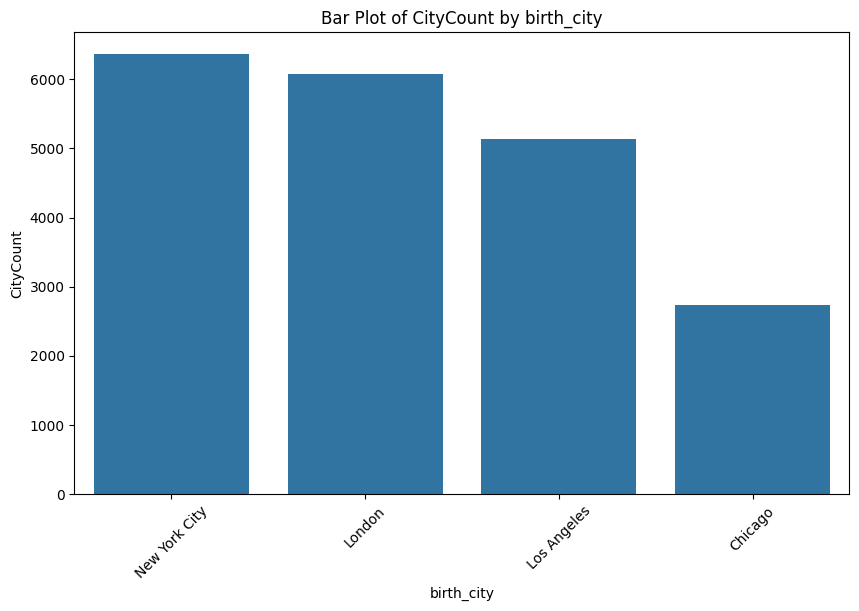

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_auto(df, plot_type=None):
    """
    Automatically generate a plot based on the dataframe and an optional plot_type.
    
    If plot_type is None, the function decides:
      - 'scatter' if at least 2 numerical columns exist,
      - 'bar' if one numerical and one categorical column exist,
      - 'pie' if one categorical column with few unique entries is available.
    """
    # Identify column types
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    
    # Optionally, use an LLM to decide on plot type if not provided
    if plot_type is None:
        # For more complex reasoning, you might send the following prompt to an LLM:
        # prompt = f"Given the dataframe columns: {list(df.columns)} with numerical: {num_cols} and categorical: {cat_cols}, which plot type (bar, scatter, or pie) is most suitable?"
        # plot_type = call_llm(prompt)  # pseudo-code for LLM integration
        #
        # For this example, we use simple heuristics:
        if len(num_cols) >= 2:
            plot_type = 'scatter'
        elif len(num_cols) == 1 and len(cat_cols) >= 1:
            plot_type = 'bar'
        elif len(cat_cols) == 1 and df[cat_cols[0]].nunique() < 10 and len(num_cols) >= 1:
            plot_type = 'pie'
        else:
            plot_type = 'bar'  # Default option

    # Generate plots based on determined plot type
    if plot_type == 'scatter':
        if len(num_cols) < 2:
            raise ValueError("Scatter plot requires at least two numerical columns")
        x, y = num_cols[0], num_cols[1]
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x=x, y=y)
        plt.title(f'Scatter Plot of {x} vs {y}')
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()

    elif plot_type == 'bar':
        if len(num_cols) >= 1 and len(cat_cols) >= 1:
            x, y = cat_cols[0], num_cols[0]
            plt.figure(figsize=(10, 6))
            sns.barplot(data=df, x=x, y=y)
            plt.title(f'Bar Plot of {y} by {x}')
            plt.xlabel(x)
            plt.ylabel(y)
            plt.xticks(rotation=45)
            plt.show()
        else:
            raise ValueError("Bar plot requires at least one categorical and one numerical column")

    elif plot_type == 'pie':
        if len(cat_cols) == 1 and len(num_cols) >= 1:
            cat = cat_cols[0]
            num = num_cols[0]
            # Aggregate data if necessary
            data = df.groupby(cat)[num].sum()
            plt.figure(figsize=(8, 8))
            plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
            plt.title(f'Pie Chart of {num} by {cat}')
            plt.show()
        else:
            raise ValueError("Pie chart requires one categorical column and one numerical column to aggregate")
    else:
        raise ValueError("Unsupported plot type. Choose 'scatter', 'bar', or 'pie'.")


plot_auto(df)


['Total_Writers']
['Gender']


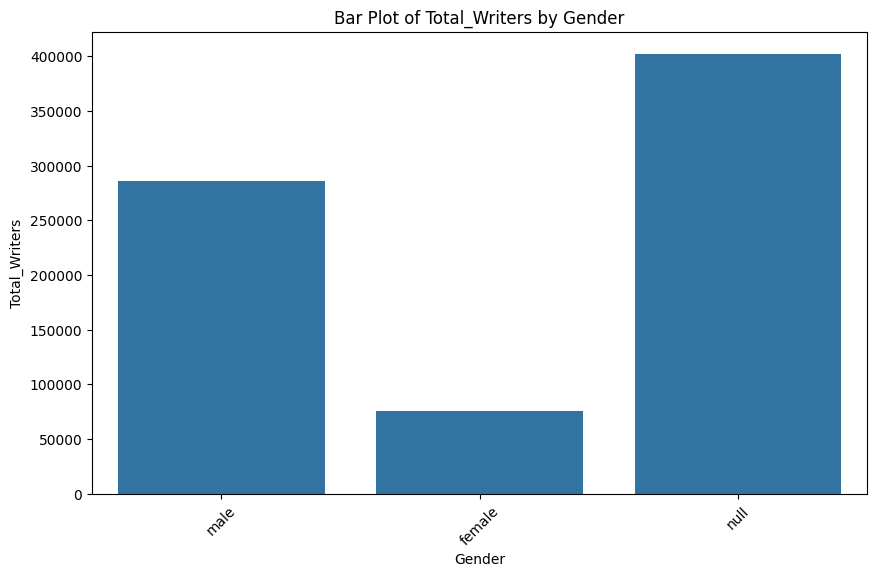

True

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def call_llm(prompt):
    """
    Placeholder function to simulate an LLM call.
    In a real implementation, this function would call an LLM API.
    For demonstration, it returns 'sum' by default.
    """
    # You can extend this function to perform more cognitive reasoning.
    return 'sum'  # Default aggregation; replace with actual LLM API call if desired.

def get_aggregation_function(df, cat, num):
    """
    Uses an LLM to decide which aggregation function to use.
    The prompt provides context for the LLM.
    """
    prompt = (
        f"You are given a dataframe with a categorical column '{cat}' and a numerical column '{num}'. "
        "The data might have multiple rows for each category. "
        "Suggest the best aggregation function (one of 'sum', 'count', or 'avg') "
        "to effectively visualize the data in a bar or pie chart. "
        "Consider that 'sum' is typically used for total values, "
        "'count' for frequency, and 'avg' for average metrics. "
        "Return only the aggregation function name."

    )
    agg_func = get_model_resp(prompt)
    print(f"LLM suggests using the '{agg_func}' aggregation function.")
    return agg_func

def plot_auto(df, plot_type=None):
    """
    Automatically generates a plot based on the dataframe.
    
    The function performs the following steps:
      1. Validates if the dataframe has sufficient columns to plot.
      2. Uses heuristics (or an LLM call) to determine the best plot type:
         - 'scatter' if there are at least 2 numerical columns.
         - 'bar' if there is one numerical and one categorical column.
         - 'pie' if there is one categorical and one numerical column.
      3. Performs aggregation (using LLM recommendations) if duplicate categorical entries exist.
      4. If the data does not meet the minimum requirements for a plot, it informs the user.
    """
    # Check if dataframe is empty
    if df.empty:
        print("The dataframe is empty. No visualization can be plotted.")
        return None

    # Identify column types
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    print(num_cols)
    print(cat_cols)

    # Check for sufficient data to plot
    if len(num_cols) == 0:
        print("No numerical data available for visualization. At least one numerical column is required.")
        return None
    if len(cat_cols) == 0 and len(num_cols) == 1:
        print("Only one numerical column present and no categorical data for meaningful visualization.")
        return None

    # Decide on plot type using heuristics (or potentially an LLM call)
    if plot_type is None:
        
        if len(num_cols) >= 2:
            plot_type = 'scatter'
        elif len(num_cols) == 1 and len(cat_cols) >= 1:
            plot_type = 'bar'
       
        else:
            # Edge case: no clear plot type can be determined
            print("No valid visualization can be plotted with the available data.")
            return None

    # Generate plots based on determined plot type
    if plot_type == 'scatter':
        if len(num_cols) < 2:
            raise ValueError("Scatter plot requires at least two numerical columns.")
        x, y = num_cols[0], num_cols[1]
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x=x, y=y)
        plt.title(f'Scatter Plot of {x} vs {y}')
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()
        return True

    elif plot_type == 'bar':
        if len(num_cols) >= 1 and len(cat_cols) >= 1:
            x, y = cat_cols[0], num_cols[0]
            # Check for duplicate categorical entries that may require aggregation
            if df[x].duplicated().any():
                agg_func = get_aggregation_function(df, x, y)
                if agg_func == 'sum':
                    aggregated = df.groupby(x)[y].sum().reset_index()
                elif agg_func == 'count':
                    aggregated = df.groupby(x)[y].count().reset_index()
                elif agg_func in ['avg', 'average']:
                    aggregated = df.groupby(x)[y].mean().reset_index()
                else:
                    raise ValueError("Unsupported aggregation function returned by LLM.")
                plot_df = aggregated
            else:
                plot_df = df
            plt.figure(figsize=(10, 6))
            sns.barplot(data=plot_df, x=x, y=y)
            plt.title(f'Bar Plot of {y} by {x}')
            plt.xlabel(x)
            plt.ylabel(y)
            plt.xticks(rotation=45)
            plt.show()
            return True
        else:
            print("Insufficient columns for a bar plot. Need at least one categorical and one numerical column.")
            return None

    

    else:
        print("Unsupported plot type. Choose 'scatter', 'bar', or 'pie'.")
        return None

# Example usage:
# df = pd.read_csv("your_data.csv")
plot_auto(df)


In [88]:
user_query = '''List director of moview" James Bond " '''
df,data_json = get_json_resp(user_query)
result = plot_auto(df)
if not  result:
    print(1)


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT D.name AS DirectorName FROM imdb.movie AS M JOIN imdb.directed_by AS DB ON M.mid  =  DB.msid JOIN imdb.director AS D ON DB.did  =  D.did WHERE lower(M.title)  =  'james bond'", "sql_query_logic": "The SQL query is constructed to retrieve the names of directors associated with the movie \"James Bond\". It joins three tables: \"movie\", \"directed_by\", and \"director\". The \"movie\" table is used to filter for the specific movie title using a lower case comparison for case-insensitive matching. The \"directed_by\" table links movies to their directors, and the \"director\" table provides the director's name.  The final SELECT statement retrieves the director's name, aliased as \"DirectorName\"."}

         DirectorName
0  Baiju Kottarakkara
1   Biju Kottarakkara
2   Sai Kishore Macha
No numerical data available for visualization. At least one numerical column is required.
1


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT D.birth_year, COUNT(*) AS MovieCount FROM imdb.director AS D JOIN imdb.directed_by AS DB ON D.did  =  DB.did GROUP BY D.birth_year", "sql_query_logic": "The query performs the following steps:\n1. It joins the `director` table (aliased as D) with the `directed_by` table (aliased as DB) using the `did` column as the join key. This links directors to the movies they directed.\n2. It groups the results by the director's birth year (`D.birth_year`).\n3. For each birth year group, it counts the number of movies directed using `COUNT(*)` and assigns the count to the alias `MovieCount`.\n4. Finally, it selects the birth year and the movie count for each group."}

     birth_year  MovieCount
0        1927.0       11375
1           NaN     3991211
2        1958.0       11122
3        1924.0        9693
4        1955.0        9533
..          ...         ...
163      1849.0           5
164      2006.0           1
165      1846.0           2
166      1843.0          49
167  

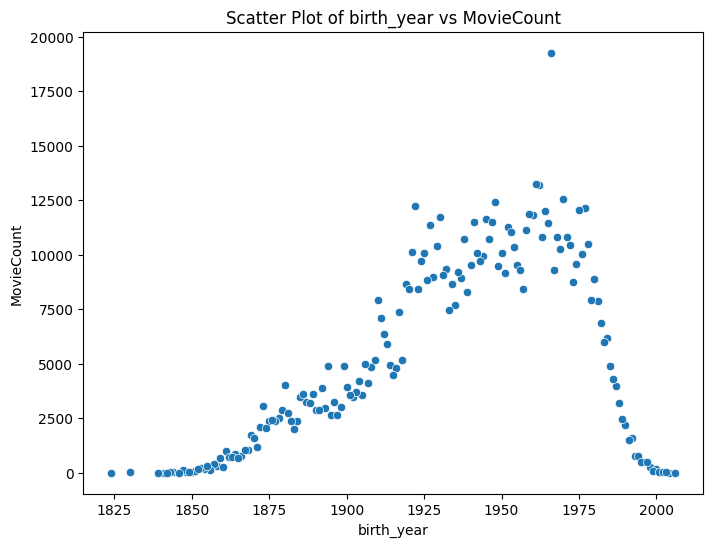

1


In [89]:
user_query = '''How many movies has each director directed, grouped by their birth year?'''
df,data_json = get_json_resp(user_query)
result = plot_auto(df)
if not  result:
    print(1)

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT A.name AS ActorName,A.birth_year AS BirthYear FROM imdb.actor AS A WHERE lower(A.gender) = 'female' ORDER BY A.birth_year DESC LIMIT 5", "sql_query_logic": "The query selects the actor's name and birth year from the 'actor' table, aliased as A. It filters for female actors by converting the gender column to lowercase and comparing it to 'female'. The results are ordered by birth year in descending order to show the youngest actors first, and the LIMIT clause restricts the output to the top 5 actors."}

              ActorName  BirthYear
0     Mary Quinn McCaig       2014
1      Melody Anita Pop       2012
2          Gabi The Dog       2012
3  Ailen Cortes Morales       2012
4   Kinga Orsolya Eröss       2012


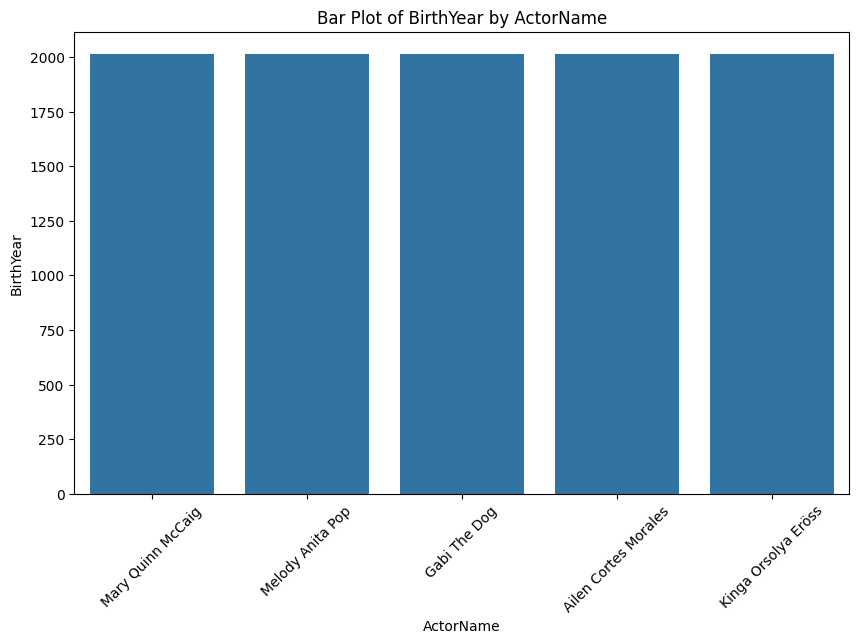

1


In [90]:
user_query = '''show top 5 young female actors by birth year'''

df,data_json = get_json_resp(user_query)
result = plot_auto(df)
if not  result:
    print(1)

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS Total_Writers, LOWER(T1.gender) AS Gender FROM imdb.writer AS T1 GROUP BY LOWER(T1.gender)", "sql_query_logic": "The query selects the count of writers and their gender from the 'writer' table.  It uses a GROUP BY clause to group the results by gender (converted to lowercase for case-insensitive comparison) and provides a count of writers for each gender as Total_Writers."}

   Total_Writers  Gender
0         286260    male
1          75773  female
2         402164    null
['Total_Writers']
['Gender']


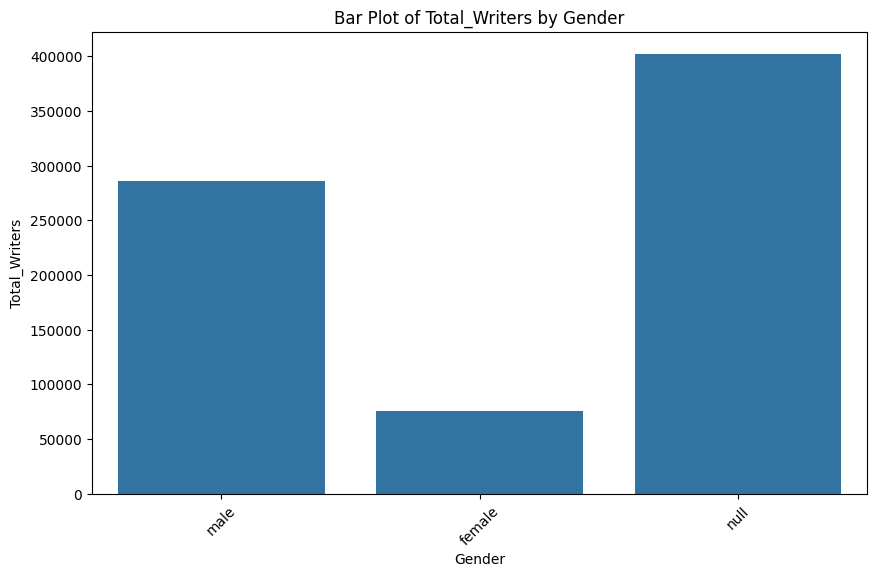

In [118]:
user_query = '''show  number of writers by gender'''

df,data_json = get_json_resp(user_query)
result = plot_auto(df)
if not  result:
    print(1)

# Text Summarisation

In [142]:
sum_prompt = '''
You are an expert summarisation agent which is a part of text2sql system. You have been given a natural langauge user question, an sql query generated by text2sql system to answer 
this user question  and dataframe which is the result of the sql query execution. Your goal is to summarise the dataframe in such a way that it answers the user question.
You Goal is to give a text summarization of the dataset based on the user question in such a way that it asnwers the user question.
dataset = {data}
user_query = {user_query}
sql_query = {sql_query}
Answer:





'''

In [164]:
import pandas as pd

def summarize_dataframe(df, user_query,sum_prompt,sql_query):
    
    
    sum_prompt =  sum_prompt.format(data=df, user_query=user_query,sql_query=sql_query)
    print(sum_prompt)
    resp = get_model_resp(sum_prompt)
    return resp

# Example usage:
# Assume df is your dataframe loaded from the text2sql output.
# df = pd.read_csv("data.csv")
user_query = '''show  number of writers by gender'''

df,data_json,sql_query = get_json_resp(user_query)
print(summarize_dataframe(df, user_query,sum_prompt,sql_query))


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS Total_Writers, LOWER(T1.gender) AS Gender FROM imdb.writer AS T1 GROUP BY T1.gender", "sql_query_logic": "The SQL query is constructed to count the number of writers by gender. It selects the count of all rows and groups them by the gender column. The gender column is converted to lowercase using LOWER() function for case-insensitive comparison. The count is aliased as Total_Writers and the gender column is aliased as Gender. The query uses the writer table from the imdb database."}

   Total_Writers  Gender
0         286260    male
1          75773  female
2         402164    null

You are an expert summarisation agent which is a part of text2sql system. You have been given a natural langauge user question, an sql query generated by text2sql system to answer 
this user question  and dataframe which is the result of the sql query execution. Your goal is to summarise the dataframe in such a way that it answers the user question.
You Goal is to give a te

In [154]:
user_query = '''How many movies did " Humphrey Bogart " act in before 1942 ?''' 


df,data_json,sql_query = get_json_resp(user_query)
print(summarize_dataframe(df, user_query,sum_prompt,sql_query))


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS MovieCount FROM imdb.movie AS M JOIN imdb.cast AS C ON M.mid  =  C.msid JOIN imdb.actor AS A ON C.aid  =  A.aid WHERE A.name  =  'Humphrey Bogart' AND M.release_year  <  1942", "sql_query_logic": "The query is constructed using three tables: movie, cast, and actor.  It starts by joining the movie table (aliased as M) with the cast table (aliased as C) using the movie ID (mid) and cast movie ID (msid). This links movies to the actors who appeared in them. Then, it joins the result with the actor table (aliased as A) using the actor ID (aid) to get the actor's name. The WHERE clause filters the results to include only movies where the actor's name is 'Humphrey Bogart' and the movie's release year is before 1942. Finally, COUNT(*) aggregates the number of matching rows, providing the total count of movies Humphrey Bogart acted in before 1942. The result is aliased as MovieCount for clarity."}

   MovieCount
0          28

You are an expert summarisation a

In [156]:
user_query = '''Find all the female actors in the movie  Saving Private Ryan '''


df,data_json,sql_query = get_json_resp(user_query)
print(summarize_dataframe(df, user_query,sum_prompt,sql_query))


c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT T1.name FROM imdb.actor AS T1 JOIN imdb.cast AS T2 ON T1.aid  =  T2.aid JOIN imdb.movie AS T3 ON T2.msid  =  T3.mid WHERE lower(T1.gender)  =  'female' AND lower(T3.title)  =  'saving private ryan'", "sql_query_logic": "The SQL query is constructed to retrieve the names of female actors who acted in the movie \"Saving Private Ryan\". It joins three tables: \"actor\", \"cast\", and \"movie\". The \"actor\" table provides actor information, including their name and gender. The \"cast\" table links actors to movies, and the \"movie\" table contains movie details. The JOIN operations connect these tables based on their respective primary and foreign keys. The WHERE clause filters the results to include only female actors ('female') and the specific movie ('Saving Private Ryan'). The lower() function is used for case-insensitive comparison of gender and movie title."}

                      name
0             Amanda Boxer
1           Kathleen Byron
2           Valerie 

In [157]:
user_query = '''Find the directors of all movies featuring " Kate Winslet "'''


df,data_json,sql_query = get_json_resp(user_query)
print(summarize_dataframe(df, user_query,sum_prompt,sql_query))

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT DISTINCT D.name AS DirectorName FROM imdb.director AS D JOIN imdb.directed_by AS DB ON D.did  =  DB.did JOIN imdb.movie AS M ON DB.msid  =  M.mid JOIN imdb.cast AS C ON M.mid  =  C.msid JOIN imdb.actor AS A ON C.aid  =  A.aid WHERE lower(A.name) LIKE '%kate winslet%'", "sql_query_logic": "The query is constructed to find the directors of movies featuring \"Kate Winslet\". It starts by selecting the distinct director names from the 'director' table, aliased as D. It then joins this table with 'directed_by' (aliased as DB) using the director ID (did), linking directors to movies.  Next, it joins with 'movie' (aliased as M) using the movie ID (msid), and then with 'cast' (aliased as C) using the movie ID (msid) to connect movies to actors. Finally, it joins with 'actor' (aliased as A) using the actor ID (aid) to get actor names. The WHERE clause filters the results to include only movies where the actor's name (converted to lowercase for case-insensitive matching) co

In [158]:
user_query = '''How many movies has each director directed, grouped by their birth year?'''


df,data_json,sql_query = get_json_resp(user_query)
print(summarize_dataframe(df, user_query,sum_prompt,sql_query))

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT D.birth_year, COUNT(*) AS MovieCount FROM imdb.director AS D JOIN imdb.directed_by AS DB ON D.did  =  DB.did GROUP BY D.birth_year", "sql_query_logic": "The query performs the following steps:\n1. It joins the `director` table (aliased as D) with the `directed_by` table (aliased as DB) using the `did` column as the join key. This links directors to the movies they directed.\n2. It groups the results by the director's birth year (`D.birth_year`).\n3. For each birth year group, it counts the number of movies directed using `COUNT(*)` and assigns the count to the alias `MovieCount`.\n4. Finally, it selects the birth year and the movie count for each group."}

     birth_year  MovieCount
0        1927.0       11375
1           NaN     3991211
2        1958.0       11122
3        1924.0        9693
4        1955.0        9533
..          ...         ...
163      1849.0           5
164      2006.0           1
165      1846.0           2
166      1843.0          49
167  

In [163]:
user_query = '''How many actors were born in " new york " after 1990 ?'''


df,data_json,sql_query = get_json_resp(user_query)
print(summarize_dataframe(df, user_query,sum_prompt,sql_query))

c:\Users\ANURAG\.conda\envs\autobi\lib\site-packages\numpy\_core\fromnumeric.py:48: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return conv.wrap(result, to_scalar=False)


{"sql_query": "SELECT COUNT(*) AS Total_Actors FROM imdb.actor WHERE lower(birth_city) = lower(\"new york\") AND birth_year > 1990", "sql_query_logic": "The SQL query is constructed to count the number of actors born in \"New York\" after 1990. It selects the count of all rows from the 'actor' table in the 'imdb' database where the lowercased 'birth_city' is equal to lowercased \"new york\" and the 'birth_year' is greater than 1990. The count is aliased as 'Total_Actors' for better readability."}

   Total_Actors
0            19

You are an expert summarisation agent which is a part of text2sql system. You have been given a natural langauge user question, an sql query generated by text2sql system to answer 
this user question  and dataframe which is the result of the sql query execution. Your goal is to summarise the dataframe in such a way that it answers the user question.
You Goal is to give a text summarization of the dataset based on the user question in such a way that it asnwers